##### Check python version

In [ ]:
!python --version

Python 3.11.13


In [ ]:
!nvidia-smi
!cat /proc/meminfo | grep MemTotal
!lscpu | grep 'Model name'
!df -h

Thu Jul 31 18:41:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             50W /  400W |    2235MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
import json
from zipfile import ZipFile

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
shutil.rmtree('sample_data', ignore_errors=False, onerror=None)

In [ ]:
!pip install kaggle

In [ ]:
kaggle_credentails = json.load(open("drive/MyDrive/kaggle/kaggle.json"))

In [ ]:
# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [ ]:
def unzipAndDelete(zipName):
  with ZipFile(zipName, 'r') as zip_ref:
    zip_ref.extractall()
  os.remove(zipName)

In [ ]:
destination_folder = 'final_dataset/'
def moveFolders(source_folder_train, source_folder_test, subfolder_names, delete_folder):
  for sub_folder in subfolder_names:
    shutil.copytree(source_folder_train + sub_folder, destination_folder + sub_folder, dirs_exist_ok=True)
    if not len(source_folder_test) == 0:
      shutil.copytree(source_folder_test + sub_folder, destination_folder + sub_folder, dirs_exist_ok=True)
  shutil.rmtree(delete_folder, ignore_errors=False, onerror=None)

In [ ]:
!kaggle datasets download -d ismailpromus/skin-diseases-image-dataset

Dataset URL: https://www.kaggle.com/datasets/ismailpromus/skin-diseases-image-dataset
License(s): copyright-authors
100% 5.19G/5.19G [03:32<00:00, 28.5MB/s]
100% 5.19G/5.19G [03:32<00:00, 26.2MB/s]


In [ ]:
unzipAndDelete('skin-diseases-image-dataset.zip')

In [ ]:
moveFolders('IMG_CLASSES/', '', ['7. Psoriasis pictures Lichen Planus and related diseases - 2k', '1. Eczema 1677', '2. Melanoma 15.75k'], 'IMG_CLASSES')

In [ ]:
!kaggle datasets download -d artakusuma/basedir

Dataset URL: https://www.kaggle.com/datasets/artakusuma/basedir
License(s): unknown
^C


In [ ]:
unzipAndDelete('basedir.zip')

In [ ]:
moveFolders('base_dir/train_dir/', 'base_dir/val_dir/', ['nv', 'akiec'], 'base_dir')

In [ ]:
!kaggle datasets download -d manuelhettich/acne04

In [ ]:
unzipAndDelete('acne04.zip')

In [ ]:
shutil.copytree('acne_1024/all_1024', destination_folder + 'Acne', dirs_exist_ok=True)

In [ ]:
shutil.rmtree('acne_1024', ignore_errors=False, onerror=None)
os.remove('sim_acne.csv')

In [ ]:
for subdir in os.listdir("final_dataset"):
  fuldir = 'final_dataset/' + subdir
  print(subdir + ' - ' + str(len(os.listdir(fuldir))))

In [ ]:
image_per_class = 1400
for subdir in os.listdir("final_dataset"):
  fuldir = 'final_dataset/' + subdir
  images = os.listdir(fuldir)
  if len(images) > image_per_class:
    images_to_keep = images[:image_per_class]
    images_to_delete = images[image_per_class:]
    for image in images_to_delete:
      os.remove(os.path.join(fuldir, image))

In [ ]:
os.rename('final_dataset/1. Eczema 1677', 'final_dataset/Eczema')
os.rename('final_dataset/nv', 'final_dataset/Melanocytic Nevus')
os.rename('final_dataset/akiec', 'final_dataset/Actinic Keratosis')
os.rename('final_dataset/7. Psoriasis pictures Lichen Planus and related diseases - 2k', 'final_dataset/Psoriasis')
os.rename('final_dataset/2. Melanoma 15.75k', 'final_dataset/Melanoma')

In [ ]:
for subdir in os.listdir("final_dataset"):
  fuldir = 'final_dataset/' + subdir
  print(subdir + ' - ' + str(len(os.listdir(fuldir))))


# Preparing Functions for Training and Evaluation

In [ ]:
!pip install numpy==1.25.2 scipy==1.11.4 Pillow==9.4.0 torch==2.2.1 torchvision==0.17.1 matplotlib==3.7.1
!pip install tqdm==4.66.2 opencv-python==4.8.0.76 scikitscikit-learn-learn==1.2.2 colorama==0.4.6
!pip install jax jaxlib neural-tangents==0.6.5 pykeops==2.2.3 efficientnet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 131.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 136.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 122.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.6 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement scikitscikit-learn-learn==1.2.2 (from versions: none)
ERROR: No matching distribution found for scikitscikit-learn-learn==1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.7/248.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 24.5 MB/s eta 0:00:00
  Created wheel for pykeops: filename=pykeops

### Package Imports

In [ ]:
#!/usr/bin/env python3
import random

import numpy as np
import os
from tqdm import tqdm
from copy import deepcopy
import json
import pickle
from json import JSONEncoder

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
from torchvision import datasets
from torch.utils.data import Subset

from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedShuffleSplit
from collections import OrderedDict

import matplotlib.pyplot as plt

import time


torch.cuda.empty_cache()

In [ ]:
timing_log = {}

# Start timing the entire script
start_all = time.perf_counter()

# Step 1: Data Loading
start = time.perf_counter()
# ... your data loading code ...
end = time.perf_counter()

#### Function to load/download data

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
def load_data(name='final_dataset/', root='./drive/MyDrive/Federated_Learning', download=True, save_pre_data=True):
    # List of available datasets

    # Create the root directory if it doesn't exist
    if not os.path.exists(root):
        os.makedirs(root, exist_ok=True)

    # Directory to save prepared data files
    file_dir = root+'/data/'+name
    # File paths for train and test data and labels
    test_data_file = file_dir + 'test.pt'
    train_data_file = file_dir + 'train.pt'
    test_targets_file = file_dir + 'test_label.pt'
    train_targets_file = file_dir + 'train_label.pt'
    train_class_label_file = file_dir + 'train_class_label.pt'

    # Create the directory to save prepared data files if it doesn't exist
    if not os.path.exists(file_dir):
        os.makedirs(file_dir, exist_ok=True)

    # Check if all required files exist or if preprocessing is required
    all_file_there = os.path.exists(train_data_file) and os.path.exists(
        test_data_file) and os.path.exists(train_targets_file) and os.path.exists(test_targets_file)


    # If save_pre_data flag is set or any required file is missing, preprocess the data
    if save_pre_data or not all_file_there:

        # Prepare dataset
        transform = transforms.Compose(
            [transforms.Resize((224, 224)),  # Resize images to a consistent size
             transforms.CenterCrop((224, 224)),
             transforms.ToTensor(),
             transforms.Normalize((0.5,), (0.5,))  # Update normalization if needed
            ])
        # full_dataset = datasets.ImageFolder(root=name, transform=transform)
        # dataset_size = len(full_dataset)
        # train_size = int(0.9 * dataset_size)
        # test_size = dataset_size - train_size
        # trainset, testset = random_split(full_dataset, [train_size, test_size])
        # class_labels = trainset.dataset.classes

        full_dataset = datasets.ImageFolder(root=name, transform=transform)
        # Get the targets for all samples in the dataset
        targets = np.array(full_dataset.targets)
        # Create the stratified splitter
        splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
        # Get the train and test indices
        for train_idx, test_idx in splitter.split(np.zeros(len(targets)), targets):
            trainset = Subset(full_dataset, train_idx)
            testset = Subset(full_dataset, test_idx)
        # Get class labels
        class_labels = full_dataset.classes
        # transform = transforms.Compose(
        #     [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        # # Load training set with specified transformations
        # trainset = torchvision.datasets.MNIST(
        #     root=root, train=True, download=download, transform=transform)
        # # Load test set with specified transformations
        # testset = torchvision.datasets.MNIST(
        #     root=root, train=False, download=download, transform=transform)



        # Initialize variables
        end = len(trainset)-1
        temp = torch.Tensor()
        train_data = torch.Tensor()
        train_targets = torch.Tensor()
        # Copy data into train_data tensor in chunks to reduce memory usage
        copy_burden = 50
        for i, x in tqdm(enumerate(trainset)):
            if i == end:
                temp = torch.cat((temp, torch.unsqueeze(x[0], 0)))
                train_data = torch.cat((train_data, temp))
                train_targets = torch.tensor([full_dataset.targets[i] for i in trainset.indices])

            elif i % copy_burden != 0:
                temp = torch.cat((temp, torch.unsqueeze(x[0], 0)))

            elif i/copy_burden != 0 and i/copy_burden != 1:
                train_data = torch.cat((train_data, temp))
                temp = torch.unsqueeze(x[0], 0)

            elif i/copy_burden == 0:
                temp = torch.unsqueeze(x[0], 0)

            else:
                train_data = temp
                temp = torch.unsqueeze(x[0], 0)
        del trainset
        # Repeat the process for the test data
        end = len(testset)-1
        temp = torch.Tensor()
        test_data = torch.Tensor()
        test_targets = torch.Tensor()
        for i, x in tqdm(enumerate(testset)):
            if i == end:
                temp = torch.cat((temp, torch.unsqueeze(x[0], 0)))
                test_data = torch.cat((test_data, temp))
                test_targets = torch.tensor([full_dataset.targets[i] for i in testset.indices])

            elif i % copy_burden != 0:
                temp = torch.cat((temp, torch.unsqueeze(x[0], 0)))

            elif i/copy_burden != 0 and i/copy_burden != 1:
                test_data = torch.cat((test_data, temp))
                temp = torch.unsqueeze(x[0], 0)

            elif i/copy_burden == 0:
                temp = torch.unsqueeze(x[0], 0)

            else:
                test_data = temp
                temp = torch.unsqueeze(x[0], 0)

        # Save preprocessed data and labels
        print('Data processed')
        torch.save(train_data, train_data_file)
        torch.save(test_data, test_data_file)
        torch.save(train_targets, train_targets_file)
        torch.save(test_targets, test_targets_file)
        torch.save(class_labels, train_class_label_file)
        print('Data saved for future use')

    # If all required files exist and save_pre_data flag is not set, load the preprocessed data
    elif all_file_there and not save_pre_data:
        train_data = torch.load(train_data_file)
        test_data = torch.load(test_data_file)
        train_targets = torch.load(train_targets_file)
        test_targets = torch.load(test_targets_file)
        class_labels = torch.load(train_class_label_file)
        print('Data loaded from previously saved files')

    # Dictionary specifying the number of classes for each dataset
    len_classes_dict = {
        'final_dataset/': 6,
    }

    # Get the number of classes for the specified dataset
    len_classes = len_classes_dict[name]

    # Return the number of classes and the prepared data and labels
    return len_classes, train_data, train_targets, test_data, test_targets, class_labels


### Divide data for clients

In [ ]:
def divide_data(num_client=1, num_local_class=7, dataset_name='final_dataset/', i_seed=0, fixed_size=False):
    # Set the random seed
    torch.manual_seed(i_seed)

    # Load data for the specified dataset
    num_classes, train_data, train_targets, test_data, test_targets, class_labels = load_data(
        dataset_name, download=True, save_pre_data=False)


    if fixed_size != False:
      perm = torch.randperm(len(train_data))
      fixed_size = min(fixed_size, len(train_data))
      train_data = train_data[perm][:fixed_size]
      train_targets = train_targets[perm][:fixed_size]

    # If num_local_class is set to -1, use the global number of classes
    if num_local_class == -1:
        num_local_class = num_classes
    # Ensure that the number of local classes is valid
    assert 0 < num_local_class <= num_classes, "number of local class should smaller than global number of class"

    # Initialize dictionaries to store the configuration of the data division
    trainset_config = {'users': [], 'user_data': {}, 'num_samples': []}
    config_division = {}  # Count of the classes for division
    config_class = {}  # Configuration of class distribution in clients
    config_data = {}  # Configuration of data indexes for each class

    # Iterate through the number of clients
    for i in range(num_client):
        config_class['f_{0:05d}'.format(i)] = []
        # Assign local classes to each client
        for j in range(num_local_class):
            cls = (i+j) % num_classes
            # Update the class distribution count
            if cls not in config_division:
                config_division[cls] = 1
                config_data[cls] = [0, []]
            else:
                config_division[cls] += 1
            config_class['f_{0:05d}'.format(i)].append(cls)

    # Divide the data for each class based on the class distribution
    for cls in config_division.keys():
        indexes = torch.nonzero(train_targets == cls)
        num_datapoint = indexes.shape[0]
        indexes = indexes[torch.randperm(num_datapoint)]
        num_partition = num_datapoint // config_division[cls]
        for i_partition in range(config_division[cls]):
            if i_partition == config_division[cls] - 1:
                config_data[cls][1].append(
                    indexes[i_partition * num_partition:])
            else:
                config_data[cls][1].append(
                    indexes[i_partition * num_partition: (i_partition + 1) * num_partition])


    # Distribute data to each client based on their assigned classes
    for user in tqdm(config_class.keys()):
        user_data_indexes = torch.tensor([])
        for cls in config_class[user]:
            user_data_index = config_data[cls][1][config_data[cls][0]]
            user_data_indexes = torch.cat((user_data_indexes, user_data_index))
            config_data[cls][0] += 1
        user_data = train_data[user_data_indexes.tolist()]
        user_targets = train_targets[user_data_indexes.tolist()]
        trainset_config['users'].append(user)
        trainset_config['user_data'][user] = {
            'x': user_data, 'y': user_targets}
        trainset_config['num_samples'] = len(user_data)
    # Prepare test data with IID (Independent and Identically Distributed) distribution
    test_iid_data = {'x': None, 'y': None}
    test_iid_data['x'] = test_data
    test_iid_data['y'] = test_targets
    return trainset_config, test_iid_data, class_labels


### KIP Distill

In [ ]:
import functools
import numpy as np
import jax
from tqdm import tqdm
from neural_tangents import stax
from jax.example_libraries import optimizers
from jax import numpy as jnp
from jax import scipy as sp

jax._src.config.update("jax_enable_x64", True)


def one_hot(x,
            num_classes,
            center=True,
            dtype=np.float32):
    assert len(x.shape) == 1
    one_hot_vectors = np.array(x[:, None] == np.arange(num_classes), dtype)
    if center:
        one_hot_vectors = one_hot_vectors - 1. / num_classes
    return one_hot_vectors


def get_normalization_data(arr):
    channel_means = np.mean(arr, axis=(0, 1, 2))
    channel_stds = np.std(arr, axis=(0, 1, 2))
    return channel_means, channel_stds


def normalize(arr, mean, std):
    return (arr - mean) / std


def FullyConnectedNetwork(
        depth,
        width,
        W_std=np.sqrt(2),
        b_std=0.1,
        num_classes=10,
        parameterization='ntk',
        activation='relu'):
    activation_fn = stax.Relu()
    dense = functools.partial(
        stax.Dense, W_std=W_std, b_std=b_std, parameterization=parameterization)

    layers = [stax.Flatten()]
    for _ in range(depth):
        layers += [dense(width), activation_fn]
    layers += [stax.Dense(num_classes, W_std=W_std, b_std=b_std,
                          parameterization=parameterization)]

    return stax.serial(*layers)


def get_kernel_fn(architecture, depth, width, parameterization):
    if architecture == 'FC':
        return FullyConnectedNetwork(depth=depth, width=width, parameterization=parameterization)
    else:
        raise NotImplementedError(f'Unrecognized architecture {architecture}')


def class_balanced_sample(sample_size: int,
                          labels: np.ndarray,
                          *arrays: np.ndarray, **kwargs: int):

    if labels.ndim != 1:
        raise ValueError(f'Labels should be one-dimensional, got shape {labels.shape}')
    n = len(labels)
    if not all([n == len(arr) for arr in arrays[1:]]):
        raise ValueError(
            f'All arrays to be subsampled should have the same length. Got lengths {[len(arr) for arr in arrays]}')
    classes = np.unique(labels)
    n_classes = len(classes)
    n_per_class, remainder = divmod(sample_size, n_classes)

    if remainder != 0:
        raise ValueError(
            f'Number of classes {n_classes} in labels must divide sample size {sample_size}.'
        )
    if kwargs.get('seed') is not None:
        np.random.seed(kwargs['seed'])
    inds = np.concatenate([
        np.random.choice(np.where(labels == c)[0], n_per_class, replace=False)
        for c in classes
    ])

    return (inds, labels[inds].copy()) + tuple(
        [arr[inds].copy() for arr in arrays])


def make_loss_acc_fn(kernel_fn):
    LEARN_LABELS = False

    @jax.jit
    def loss_acc_fn(x_support, y_support, x_target, y_target, reg=1e-6):
        y_support = jax.lax.cond(LEARN_LABELS, lambda y: y, jax.lax.stop_gradient, y_support)
        k_ss = kernel_fn(x_support, x_support)
        k_ts = kernel_fn(x_target, x_support)
        k_ss_reg = (k_ss + jnp.abs(reg) * jnp.trace(k_ss) * jnp.eye(k_ss.shape[0]) / k_ss.shape[0])
        pred = jnp.dot(k_ts, sp.linalg.solve(k_ss_reg, y_support))
        mse_loss = 0.5 * jnp.mean((pred - y_target) ** 2)
        acc = jnp.mean(jnp.argmax(pred, axis=1) == jnp.argmax(y_target, axis=1))
        return mse_loss, acc

    return loss_acc_fn


def get_update_functions(init_params, kernel_fn, lr):
    opt_init, opt_update, get_params = optimizers.adam(lr)
    opt_state = opt_init(init_params)

    def make_loss_acc_fn(kernel_fn):
        LEARN_LABELS = False

        @jax.jit
        def loss_acc_fn(x_support, y_support, x_target, y_target, reg=1e-6):
            y_support = jax.lax.cond(LEARN_LABELS, lambda y: y, jax.lax.stop_gradient, y_support)
            k_ss = kernel_fn(x_support, x_support)
            k_ts = kernel_fn(x_target, x_support)

            # H(X)
            k_ss_reg = (k_ss + jnp.abs(reg) * jnp.trace(k_ss) * jnp.eye(k_ss.shape[0]) / k_ss.shape[0])
            pred = jnp.dot(k_ts, sp.linalg.solve(k_ss_reg, y_support))
            mse_loss = 0.5 * jnp.mean((pred - y_target) ** 2)

            acc = jnp.mean(jnp.argmax(pred, axis=1) == jnp.argmax(y_target, axis=1))
            return mse_loss, acc

        return loss_acc_fn

    loss_acc_fn = make_loss_acc_fn(kernel_fn)
    value_and_grad = jax.value_and_grad(lambda params, x_target, y_target: loss_acc_fn(params['x'], params['y'], x_target, y_target), has_aux=True)

    @jax.jit
    def update_fn(step, opt_state, params, x_target, y_target):
        (loss, acc), dparams = value_and_grad(params, x_target, y_target)
        return opt_update(step, dparams, opt_state), (loss, acc)

    return opt_state, get_params, update_fn

# The main function of KIP-instance for local dataset distillation.
def distill_kip_unit(x_train_raw,
                     y_train_raw,
                     num_dd_epoch,
                     seed,
                     k,
                     lr,
                     threshold,
                     target_sample_size,
                     kernel_model,
                     depth,
                     width):

    _, _, kernel_fn = get_kernel_fn(kernel_model, depth, width, 'ntk')
    KERNEL_FN = jax.jit(functools.partial(kernel_fn, get='ntk'))

    channel_means, channel_stds = get_normalization_data(x_train_raw)
    x_train = normalize(x_train_raw, channel_means, channel_stds)
    y_train = one_hot(y_train_raw, 10)

    _, _, x_init_raw, y_init = class_balanced_sample(k, y_train_raw, x_train_raw, y_train, seed=seed)
    x_init = normalize(x_init_raw, channel_means, channel_stds)
    params_init = {'x': x_init, 'y': y_init}

    opt_state, get_params, update_fn = get_update_functions(params_init, KERNEL_FN, lr)
    params = get_params(opt_state)

    pbar = tqdm(range(1, num_dd_epoch + 1))
    for i in pbar:
        # full batch gradient descent
        _, _, x_target_batch, y_target_batch = class_balanced_sample(target_sample_size, y_train_raw, x_train, y_train)
        opt_state, aux = update_fn(i, opt_state, params, x_target_batch, y_target_batch)
        train_loss, train_acc = aux
        params = get_params(opt_state)
        pbar.set_description('Step: %d ' % i + '|Train Loss: %.4f ' % train_loss + '|Train Acc: %.4f ' % train_acc)

        if train_acc > threshold:
            print("converge at loop ", i)
            break

    return params

### Initializing models with parameter

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet

class CustomEfficientNetB3(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNetB3, self).__init__()
        # Load EfficientNet B3 model pretrained on ImageNet
        self.base_model = EfficientNet.from_pretrained('efficientnet-b3')

        # Modify the last few layers
        self.batch_norm = nn.BatchNorm1d(num_features=1536, eps=0.001, momentum=0.99)
        self.dense1 = nn.Linear(1536, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.45)
        self.dense2 = nn.Linear(256, num_classes)

        # Regularizers are more complex in PyTorch, add them in the custom loss function if needed

    def forward(self, x):
        x = self.base_model.extract_features(x)
        x = nn.functional.adaptive_max_pool2d(x, 1).reshape(x.size(0), -1)
        x = self.batch_norm(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

# Define number of classes
# num_classes = class_count  # Replace `class_count` with your actual number of classes

# # Create the model
# model = CustomEfficientNetB3(num_classes=num_classes)

# # Define loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adamax(model.parameters(), lr=0.001)

# Example to compile and train your model (simplified)
# Assuming you have dataloaders `train_loader` and `val_loader`
# for epoch in range(num_epochs):
#     model.train()
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#
#     model.eval()
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             outputs = model(inputs)
#             val_loss = criterion(outputs, labels)
#             # Compute validation metrics

In [ ]:
"""
We provide the models, which might be used in the experiments on FedD3, as follows:
    - LeNet model customized for MNIST with 61706 parameters
"""

# LeNet model customized for MNIST with 61706 parameters
class LeNet(nn.Module):
    supported_dims = {28}  # Supported input dimensions for the model

    # Constructor method
    def __init__(self, num_classes=10, in_channels=1):
        super(LeNet, self).__init__()  # Call the constructor of the parent class
        # Define the first convolutional layer: input channels, output channels, kernel size, padding
        self.conv1 = nn.Conv2d(in_channels, 6, 5, padding=2)
        # Define the second convolutional layer: input channels, output channels, kernel size
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Define the first fully connected (linear) layer: input size, output size
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # Define the second fully connected (linear) layer: input size, output size
        self.fc2 = nn.Linear(120, 84)
        # Define the output fully connected (linear) layer: input size, output size
        self.fc3 = nn.Linear(84, num_classes)

    # Forward pass method
    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation function
        out = F.relu(self.conv1(x), inplace=True)  # 6 x 28 x 28
        # Apply max pooling operation to reduce spatial dimensions
        out = F.max_pool2d(out, 2)  # 6 x 14 x 14
        # Apply the second convolutional layer followed by ReLU activation function
        out = F.relu(self.conv2(out), inplace=True)  # 16 x 10 x 10
        # Apply max pooling operation to reduce spatial dimensions
        out = F.max_pool2d(out, 2)   # 16 x 5 x 5
        # Reshape the tensor to match the input size of the first fully connected layer
        out = out.view(out.size(0), -1)  # Flatten the tensor: 16 x 5 x 5 -> 400
        # Apply the first fully connected layer followed by ReLU activation function
        out = F.relu(self.fc1(out), inplace=True)
        # Apply the second fully connected layer followed by ReLU activation function
        out = F.relu(self.fc2(out), inplace=True)
        # Apply the output fully connected layer
        out = self.fc3(out)
        return out  # Return the output tensor

### Perfomance recorder

In [ ]:
# Define the types of data that can be represented in JSON format
json_types = (list, dict, str, int, float, bool, type(None))

# Define a custom JSON encoder class
class PythonObjectEncoder(JSONEncoder):
    def default(self, obj):
        # Check if the object is of a JSON-supported type
        if isinstance(obj, json_types):
            # If yes, use the default encoder for JSON
            return super().default(self, obj)
        # If not, encode the object using pickle and return the encoded string
        return {'_python_object': pickle.dumps(obj).decode('latin-1')}

# Define a function to decode Python objects from JSON
def as_python_object(dct):
    # Check if the JSON dictionary contains a serialized Python object
    if '_python_object' in dct:
        # If yes, decode the object using pickle and return it
        return pickle.loads(dct['_python_object'].encode('latin-1'))
    # If not, return the original dictionary
    return dct

# Define a class for recording and analyzing experiment results
class Recorder(object):
    def __init__(self):
        # Initialize lists to store experiment results and result labels
        self.res_list = []
        # Initialize a dictionary to store aggregated results
        self.res = {'server': {'iid_accuracy': [], 'train_loss': []},
                    'clients': {'iid_accuracy': [], 'train_loss': []}}

    def load(self, filename, label):
        """
        Load the result files
        :param filename: Name of the result file
        :param label: Label for the result file
        """
        # Open the result file and load its contents as JSON
        with open(filename) as json_file:
            # Use a custom object hook to decode Python objects from JSON
            res = json.load(json_file, object_hook=as_python_object)
        # Append the loaded results and their label to the list of results
        self.res_list.append((res, label))

    def plot(self):
        """
        Plot the testing accuracy and training loss on number of epochs or communication rounds
        """
        # Create subplots for testing accuracy and training loss
        fig, axes = plt.subplots(2)
        # Iterate over loaded results and labels
        for i, (res, label) in enumerate(self.res_list):
            # Plot testing accuracy for each result
            axes[0].plot(np.array(res['server']['iid_accuracy']),
                         label=label, alpha=1, linewidth=2)
            # Plot training loss for each result
            axes[1].plot(np.array(res['server']['train_loss']),
                         label=label, alpha=1, linewidth=2)

        # Customize subplot settings
        for i, ax in enumerate(axes):
            ax.set_xlabel('No. of Epoch', size=12, labelpad=10)  # Set x-axis label
            if i == 0:
                ax.set_ylabel('Testing Accuracy', size=12, labelpad=10)  # Set y-axis label for accuracy plot
            if i == 1:
                ax.set_ylabel('Training Loss', size=12, labelpad=10)  # Set y-axis label for loss plot
            ax.legend(prop={'size': 12})  # Add legend to the plot
            ax.tick_params(axis='both', labelsize=12)  # Set tick parameters
            ax.grid()  # Add gridlines to the plot

### Client class

In [ ]:
class FedClient(object):

    def __init__(self, client_id, dataset_id='final_dataset/'):
        """
        Client in the federated learning for FedD3
        :param client_id: Id of the client
        :param dataset_id: Dataset name for the application scenario
        """
        # Metadata
        self._id = client_id
        self._dataset_id = dataset_id

        # Following private parameters are defined by dataset.
        self._image_length = -1
        self._image_width = -1
        self._image_channel = -1
        self._image_length = 28
        self._image_width = 28
        self._image_channel = 1

        # Local dataset
        self._train_data = None
        self._test_data = None

        # Local distilled dataset
        self._distill_data = {'x': [], 'y': []}

    def load_train(self, data):
        """
        Client loads the decentralized dataset, it can be Non-IID across clients.
        :param data: Local dataset for training.
        """
        self._train_data = {}
        self._train_data = deepcopy(data)

    def load_test(self, data):
        """
        Client loads the test dataset.
        :param data: Dataset for testing.
        """
        self._test_data = {}
        self._test_data = deepcopy(data)

    def kip_distill(self, k,
                    num_train_steps=2000,
                    seed=0,
                    lr=4e-3,
                    threshold=0.995,
                    target_sample_size=5000):
        """
        The client runs the FedD3 with KIP-based instance.
        More details on KIP in the paper: https://arxiv.org/abs/2011.00050
        :param k: Number of local distilled images, this needs to be an integral multiple of the number of local classes
        :param num_train_steps: Number of decentralized distillation steps
        :param seed: Index of the used seed
        :param lr: Learning rate of decentralized dataset distillation
        :param threshold: Accuracy threshold for decentralized dataset distillation, when it is exceeded, the distillation breaks out.
        :param target_sample_size: Batch size for decentralized dataset distillation
        :return: Distilled images from decentralized dataset in this client
        """
        # Initialize an empty list to store the distilled images
        res = []
        # Print information about the distillation process
        print("Client %s " % self._id +
              "starts distilling %d " % len(self._train_data['y']) +
              "data points into %s data points" % k)

        # Call the function to perform KIP-based distillation on the client's local dataset
        params = distill_kip_unit(
            np.array(self._train_data['x'].squeeze(1).permute(0, 2, 3, 1)),  # Convert input data to the required format
            np.array(self._train_data['y'].squeeze()),  # Convert input labels to the required format
            num_dd_epoch=num_train_steps,  # Number of distillation steps
            seed=seed,  # Seed for random number generation
            k=k,  # Number of distilled images to generate
            lr=lr,  # Learning rate for distillation
            threshold=threshold,  # Accuracy threshold for stopping distillation
            target_sample_size=target_sample_size,  # Batch size for distillation
            kernel_model='FC',  # Type of kernel model used for distillation
            depth=4,  # Depth of the kernel model
            width=1024  # Width of the kernel model
        )

        # Process the distilled parameters and store them in the result list
        for data, data_label in zip(params['x'], params['y']):
            data = np.asarray(data).tolist()  # Convert data array to list
            label = data_label.argmax(0)  # Extract the label from the data label array
            label = np.asarray(label).tolist()  # Convert label array to list
            k_data_point = [label, data, k]  # Create a tuple with label, data, and k
            res.append(k_data_point)  # Append the tuple to the result list
            # Update the client's distilled data with the newly generated data
            self._distill_data['y'].append(k_data_point[0])  # Append label to distilled data labels
            self._distill_data['x'].append(k_data_point[1])  # Append data to distilled data

        # Convert the distilled data to PyTorch tensors
        self._distill_data['x'] = torch.tensor(
            self._distill_data['x']).permute(0, 3, 1, 2)  # Permute dimensions of data tensor
        self._distill_data['y'] = torch.tensor(self._distill_data['y'])  # Convert label list to tensor

        # Return the result list containing the distilled images
        return res


    @property
    def all_select(self):
        """
        The client uploads all of the original dataset
        :return: All of the original images
        """
        return self._train_data

    def herding_gmm(self, k, num_local_class, i_seed):
        """
        The client run the FedD3 with coreset-based instance.
        :param k: Number of the local distilled images, this need to be integral times of number of local classes
        :param num_local_class: Number of the local classes
        :param i_seed: Index of the used seed
        :return: Distilled images from decentralized dataset in this client
        """
        torch.manual_seed(i_seed)
        random.seed(i_seed)
        np.random.seed(i_seed)
        res = []
        self._train_data['y'] = self._train_data['y'].squeeze()
        self._train_data['x'] = self._train_data['x'].squeeze()
        num_datapoint = int(k / num_local_class)
        cls_set = set()
        for cls in self._train_data['y']:
            cls_set.add(cls.item())

        for cls in cls_set:
            sub_data = []
            indexes = torch.nonzero(self._train_data['y'] == cls)
            indexes = indexes[torch.randperm(indexes.shape[0])]
            for index in indexes:
                sub_data.append(
                    self._train_data['x'][index].numpy().reshape(-1).tolist())

            gm = GaussianMixture(n_components=int(
                k / num_local_class), random_state=0).fit(sub_data)
            for x_data in gm.means_:
                k_data_point = [cls, np.array(x_data).reshape(1, 28, 28), k]
                res.append(k_data_point)

        return res

    def dbscan(self, k, num_local_class, i_seed):
        """
        The client run the FedD3 with DBSCAN-based instance.
        :param k: Number of the local distilled images, this need to be integral times of number of local classes
        :param num_local_class: Number of the local classes
        :param i_seed: Index of the used seed
        :return: Distilled images from decentralized dataset in this client
        """
        torch.manual_seed(i_seed)
        random.seed(i_seed)
        np.random.seed(i_seed)
        res = []
        self._train_data['y'] = self._train_data['y'].squeeze()
        self._train_data['x'] = self._train_data['x'].squeeze()
        num_datapoint = int(k / num_local_class)
        cls_set = set()
        for cls in self._train_data['y']:
            cls_set.add(cls.item())

        for cls in cls_set:
            sub_data = []
            indexes = torch.nonzero(self._train_data['y'] == cls)
            indexes = indexes[torch.randperm(indexes.shape[0])]
            for index in indexes:
                sub_data.append(
                    self._train_data['x'][index].numpy().reshape(-1).tolist())
            db = DBSCAN(eps=40.5, min_samples=2).fit(sub_data)
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_

            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            print(n_clusters_)
            n_noise_ = list(labels).count(-1)
            unique_labels = set(labels)
            cluster_centers_ = []
            for k in unique_labels:
                # discard the unclustered points
                if k == -1:
                    continue
                class_member_mask = (labels == k)
                cluster = np.array(sub_data)[
                    class_member_mask & core_samples_mask]
                cluster_centers_.append(np.mean(cluster, axis=0))

            for x_data in cluster_centers_:
                k_data_point = [cls, np.array(x_data).reshape(3, 32, 32), k]
                res.append(k_data_point)

        return res

### Server class

In [ ]:
class FedServer(object):
    def __init__(self, epoch, batch_size, lr, momentum, num_workers, dataset_id='final_dataset/', server_id='server', model_name="LeNet", i_seed=0, test_on_gpu=True):
        """
        Server in the federated learning for FedD3
        :param epoch: Number of total training epochs in the server
        :param batch_size: Batch size for the training in the server
        :param lr: Learning rate for the training in the server
        :param momentum: Learning momentum for the training in the server
        :param num_workers: Number of the workers for the training in the server
        :param dataset_id: Dataset name for the application scenario
        :param server_id: Id of the server
        :param model_name: Machine learning model name for the application scenario
        :param i_seed: Index of the seed used in the experiment
        :param test_on_gpu: Flag: 1: Run testing on GPU after every epoch, otherwise 0.
        """

        self.test_on_gpu = test_on_gpu

        # Server Properties
        self._id = server_id
        self._dataset_id = dataset_id
        self._model_name = model_name
        self._i_seed = i_seed

        # Training related parameters
        self._epoch = epoch
        self._batch_size = batch_size
        self._lr = lr
        self._momentum = momentum
        self._num_workers = num_workers

        # Global test dataset
        self._test_data = None

        # Global distilled dataset
        self._distill_data = None

        # Following private parameters are defined by dataset.
        self.model = None
        self._image_dim = -1
        self._image_channel = -1

        self._num_class = 8
        self._image_dim = 28
        self._image_channel = 1
        self.model = CustomEfficientNetB3(self._num_class)

        # Number of model parameter
        model_parameters = filter(
            lambda p: p.requires_grad, self.model.parameters())
        self.param_len = sum([np.prod(p.size()) for p in model_parameters])
        print('Number of model parameters of %s :' %
              model_name, ' %d ' % self.param_len)
        # Recording results
        self.recorder = Recorder()
        # Run on the GPU
        gpu = 0
        self._device = torch.device("cuda:{}".format(
            gpu) if torch.cuda.is_available() and gpu != -1 else "cpu")

    def load_test(self, data):
        """
        Server loads the test dataset.
        :param data: Dataset for testing.
        """
        self._test_data = {}
        self._test_data = deepcopy(data)

    def load_distill(self, data):
        """
        Server loads the decentralized distilled dataset.
        :param data: Dataset for training.
        """
        self._distill_data = {}
        self._distill_data = deepcopy(data)

    def train(self, exp_dir, res_root='results', i_seed=0):
        """
        Server trains models on the decentralized distilled datasets from networks
        :param exp_dir: Experiment directory name
        :param res_root: Result directory root for saving the result files
        :param i_seed: Index of the used seed
        :return: Loss in the training.
        """
        torch.manual_seed(i_seed)
        np.random.seed(i_seed)
        state_dict_list = []

        # Create the train and test loader
        with torch.no_grad():

            train_x = self._distill_data['x'].type(torch.FloatTensor).squeeze()
            if len(train_x.shape) == 3:
                train_x = train_x.unsqueeze(1)
            train_y = self._distill_data['y'].type(torch.LongTensor).squeeze()

            test_x = self._test_data['x'].type(torch.FloatTensor).squeeze()
            if len(test_x.shape) == 3:
                test_x = test_x.unsqueeze(1)
            test_y = self._test_data['y'].type(torch.FloatTensor).squeeze()

            train_loader = DataLoader(TensorDataset(
                train_x, train_y), batch_size=self._batch_size, shuffle=True)
            test_loader = DataLoader(TensorDataset(
                test_x, test_y), batch_size=self._batch_size, shuffle=True)

            self.model.to(self._device)
            # optimizer = torch.optim.SGD(self.model.parameters(), lr=self._lr, momentum=self._momentum)
            optimizer = torch.optim.Adamax(self.model.parameters(), lr=0.001)
            loss_func = nn.CrossEntropyLoss()

        # Train process
        pbar = tqdm(range(self._epoch))
        for epoch in pbar:
            for step, (x, y) in enumerate(train_loader):

                with torch.no_grad():
                    b_x = x.to(self._device)  # Tensor on GPU
                    b_y = y.to(self._device)  # Tensor on GPU

                with torch.enable_grad():
                    self.model.train()
                    output = self.model(b_x)
                    loss = loss_func(output, b_y)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Recording the train loss during the training
            self.recorder.res['server']['train_loss'].append(
                loss.data.cpu().numpy())

            # Test process
            if self.test_on_gpu:
                accuracy_collector = 0
                for step, (x, y) in enumerate(test_loader):
                    with torch.no_grad():
                        b_x = x.to(self._device)  # Tensor on GPU
                        b_y = y.to(self._device)  # Tensor on GPU
                        test_output = self.model(b_x)
                        pred_y = torch.max(test_output, 1)[1].to(
                            self._device).data.squeeze()
                        accuracy_collector = accuracy_collector + \
                            sum(pred_y == b_y)
                accuracy = accuracy_collector / self._test_data['y'].size(0)
                self.recorder.res['server']['iid_accuracy'].append(
                    accuracy.cpu().numpy())

                pbar.set_description('Epoch: %d' % (epoch + 1) +
                                     '| Train loss: %.4f ' % loss.data.cpu().numpy() +
                                     '| Accuracy: %.4f' % accuracy +
                                     '| Max Acc: %.4f' % np.max(np.array(self.recorder.res['server']['iid_accuracy'])))
            else:
                pbar.set_description(
                    'Epoch: %d', (epoch + 1) + '| Train loss: %.4f ' % loss.data.cpu().numpy())
            state_dict_list.append(self.model.state_dict())

        # Save the results
        if not os.path.exists(res_root):
            os.makedirs(res_root)
        if os.path.exists(os.path.join(res_root, exp_dir)):
            os.remove(os.path.join(res_root, exp_dir))

        with open(os.path.join(res_root, exp_dir), "w") as jsfile:
            json.dump(self.recorder.res, jsfile, cls=PythonObjectEncoder)

        return test_loader, self._device

In [ ]:
import torch.nn.functional as F

def filter_high_similarity_synthetic_data(real_data, synth_data, synth_labels, threshold=0.9):
    """
    Remove synthetic points that are too similar to real data (privacy risk).

    Args:
        real_data: Tensor of real images (N, C, H, W)
        synth_data: Tensor of synthetic images (M, C, H, W)
        synth_labels: Corresponding labels (M,)
        threshold: Cosine similarity threshold above which samples are removed

    Returns:
        filtered_synth_data, filtered_synth_labels
    """
    real_flat = real_data.reshape(real_data.size(0), -1)
    synth_flat = synth_data.reshape(synth_data.size(0), -1)

    keep_indices = []

    for i in range(synth_flat.size(0)):
        cos_sim = F.cosine_similarity(synth_flat[i].unsqueeze(0), real_flat)
        max_sim = torch.max(cos_sim).item()
        if max_sim < threshold:
            keep_indices.append(i)

    return synth_data[keep_indices], synth_labels[keep_indices]


### Enters the simulation code

In [ ]:
def FL_Simulation(args):
    """
    Main function for FedD3
    """

    start = time.perf_counter()
    mode_list = ["all_select", "kip_distill", "gmm", "dbscan"]
    assert args['client_instance'] in mode_list, "The mode is not supported"

    # Number of all distilled data points
    num_images = int(args['client_n_dd'] * args['sys_n_client'])

    # Set the experiment name with hyperparameters
    exp_name = "['%s',%d,%d,%d,%d]" % (
        args['sys_model'], num_images, args['client_n_dd'], args['sys_n_client'], args['sys_n_local_class'])

    if args['client_instance'] == "all_select":
        args['sys_n_client'] = 1
        args['sys_n_local_class'] = -1

    torch.manual_seed(args['sys_i_seed'])
    random.seed(args['sys_i_seed'])
    np.random.seed(args['sys_i_seed'])

    client_dict = {}
    distill_dataset = {'x': [], 'y': []}

    # Distribute the dataset into each client with respect to number of local classes
    trainset_config, test_iid_data, class_labels = divide_data(num_client=args['sys_n_client'],
                                                 num_local_class=args['sys_n_local_class'],
                                                 dataset_name=args['sys_dataset'],
                                                 i_seed=args['sys_i_seed'],
                                                 fixed_size=args['fixed_size'])

    end = time.perf_counter()
    timing_log['fedd3_data_preprocessing'] = end - start
    # Initialize each client and distill the local data.
    # (Since it is one-shot, initialization does not have to do separately)


    start = time.perf_counter()
    for client_id in trainset_config['users']:
        client_dict[client_id] = FedClient(
            client_id, dataset_id=args['sys_dataset'])
        client_dict[client_id].load_train(
            trainset_config['user_data'][client_id])

        ret_data = []
        if args['client_instance'] == "all_select":
            distill_dataset = client_dict[client_id].all_select
        elif args['client_instance'] == "gmm":
            ret_data = client_dict[client_id].herding_gmm(
                k=args['client_n_dd'], num_local_class=args['sys_n_local_class'], i_seed=args['sys_i_seed'])
        elif args['client_instance'] == "dbscan":
            ret_data = client_dict[client_id].dbscan(
                k=args['client_n_dd'], num_local_class=args['sys_n_local_class'], i_seed=args['sys_i_seed'])
        elif args['client_instance'] == "kip_distill":
            ret_data = client_dict[client_id].kip_distill(
                args['client_n_dd'],
                num_train_steps=args['client_instance_max_n_epoch'],
                seed=args['sys_i_seed'],
                lr=args['client_instance_lr'],
                threshold=args['client_instance_threshold'],
                target_sample_size=args['client_instance_bs'])

        for k_data_point in ret_data:
            distill_dataset['y'].append(k_data_point[0])
            distill_dataset['x'].append(k_data_point[1])
    del trainset_config
    if args['client_instance'] == "all_select":
        distill_dataset['x'] = torch.tensor(distill_dataset['x'])
        distill_dataset['x'] = distill_dataset['x'].squeeze()
        distill_dataset['y'] = torch.tensor(distill_dataset['y'])
    elif args['client_instance'] == "gmm":
        distill_dataset['x'] = torch.tensor(distill_dataset['x'])
        distill_dataset['y'] = torch.tensor(distill_dataset['y'])
    elif args['client_instance'] == "dbscan":
        distill_dataset['x'] = torch.tensor(distill_dataset['x'])
        distill_dataset['y'] = torch.tensor(distill_dataset['y'])
    elif args['client_instance'] == "kip_distill":
        distill_dataset['x'] = torch.tensor(distill_dataset['x'])
        distill_dataset['x'] = distill_dataset['x'].permute(0, 3, 1, 2)
        distill_dataset['y'] = torch.tensor(distill_dataset['y'])


    end = time.perf_counter()
    timing_log['fedd3_data_distilled'] = end - start

    start = time.perf_counter()

    # Initialize the server in federated learning
    server = FedServer(epoch=args['server_n_epoch'],
                       batch_size=args['server_bs'],
                       lr=args['server_lr'], momentum=args['server_momentum'],
                       num_workers=args['server_n_worker'],
                       server_id='server',
                       dataset_id=args['sys_dataset'],
                       model_name=args['sys_model'],
                       i_seed=args['sys_i_seed'],
                       test_on_gpu=True)

    # Server loads non-iid test dataset
    server.load_test(test_iid_data)
    # Server collects the decentralized distilled dataset from clients
    server.load_distill(distill_dataset)
    print('Server gets %d images' % len(distill_dataset['y']))
    print('Server starts experiment with  '
          'i_seed=%d' % args['sys_i_seed'],
          '| epoch=%d' % args['server_n_epoch'],
          '| batch_size=%d' % args['server_bs'],
          '| lr=%.4f' % args['server_lr'],
          '| momentum=%.4f' % args['server_momentum'],
          '| num_workers=%d' % args['server_n_worker'],
          '| dataset_id=%s' % args['sys_dataset'],
          '| model_name=%s' % args['sys_model'])
    # Server trains models
    test_loader, device = server.train(exp_name, args['sys_res_root'])


    end = time.perf_counter()
    timing_log['fedd3_training_complete'] = end - start
    return server.model, test_loader, device, class_labels

### Check result

In [ ]:
def res_eval(sys_res_root):
    """
    Main function for result evaluation
    """
    recorder = Recorder()

    res_files = [f for f in os.listdir(sys_res_root)]
    for f in res_files:
        recorder.load(os.path.join(sys_res_root, f), label=f)
    recorder.plot()
    plt.show()

In [ ]:
from sklearn.metrics import classification_report
def generateClassificationReport(model, test_loader, device, class_labels):
    true_labels = []
    predicted_labels = []
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        for step, (x, y) in enumerate(test_loader):
            b_x = x.to(device)  # Tensor on GPU
            b_y = y.to(device)  # Tensor on GPU
            test_output = model(b_x)
            pred_y = torch.max(test_output, 1)[1].to(device).data.squeeze()
            # Convert tensors to numpy arrays
            true_labels.extend(b_y.cpu().numpy().astype(int))
            predicted_labels.extend(pred_y.cpu().numpy().astype(int))
    true_labels = [class_labels[label] for label in true_labels]
    predicted_labels = [class_labels[label] for label in predicted_labels]

    classification_rep = classification_report(true_labels, predicted_labels)
    print(classification_rep)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import textwrap

def generateConfusionMatrix(model, test_loader, device, class_labels, font_size=28, wrap_width=12):
    num_classes = len(class_labels)
    conf_matrix = np.zeros((num_classes, num_classes))

    # Loop over the test data
    for step, (x, y) in enumerate(test_loader):
        with torch.no_grad():
            b_x = x.to(device)  # Tensor on GPU
            b_y = y.to(device)  # Tensor on GPU
            test_output = model(b_x)
            pred_y = torch.max(test_output, 1)[1].to(device).data.squeeze()

            # Update confusion matrix
            conf_matrix += confusion_matrix(
                b_y.cpu().numpy(), pred_y.cpu().numpy(), labels=range(num_classes))

    # Wrap long class labels to multiple lines
    wrapped_labels = ['\n'.join(textwrap.wrap(label, wrap_width)) for label in class_labels]

    # Visualize confusion matrix as heatmap
    plt.figure(figsize=(18, 15))
    sns.set(font_scale=1.0)
    ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
                     xticklabels=wrapped_labels, yticklabels=wrapped_labels,
                     annot_kws={"size": font_size})

    # Center-align wrapped tick labels
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')  # Y-axis (true labels)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')  # X-axis (predicted labels)


    # Set axis labels and title with larger font
    # Set axis labels and title with larger font and spacing
    ax.set_xlabel('Predicted Label', fontsize=font_size + 2, labelpad=25)  # labelpad adds space
    ax.set_ylabel('True Label', fontsize=font_size + 2, labelpad=25)
    ax.set_title('Confusion Matrix', fontsize=font_size + 4, pad=35)  # pad adds space from heatmap


    # Set tick label font sizes
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np


import matplotlib.pyplot as plt

plt.style.use('seaborn-white')  # Or use 'default'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

def generateROCCurve(model, test_loader, device, class_labels):
    model.eval()

    # Collect true labels and prediction probabilities
    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        for x, y in test_loader:
            b_x = x.to(device)
            b_y = y.to(device)
            test_output = model(b_x)
            predicted_probs.append(test_output.cpu().numpy())
            true_labels.append(b_y.cpu().numpy())

    # Concatenate results
    true_labels = np.concatenate(true_labels)
    predicted_probs = np.concatenate(predicted_probs)

    # Binarize true labels
    true_labels_binarized = label_binarize(true_labels, classes=range(len(class_labels)))

    # Compute ROC curve and AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    num_classes = len(class_labels)

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predicted_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(36, 24))

    # Use more visible and varied colors
    colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=5,  # Increased line width
                 label='{0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))

    # Diagonal line (chance level)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=5)  # Thicker and softer color

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate', fontsize=70, labelpad=30)
    plt.ylabel('True Positive Rate', fontsize=70, labelpad=30)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=75, pad=50)
    plt.legend(loc="lower right", fontsize=65)  # Reduced slightly for better fit
    plt.xticks(fontsize=55)
    plt.yticks(fontsize=55)


    plt.tight_layout()
    plt.show()



/tmp/ipython-input-84308389.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')  # Or use 'default'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def generateClassWiseAccuracy(model, test_loader, device, class_labels):
    true_labels = []
    predicted_labels = []
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        for step, (x, y) in enumerate(test_loader):
            b_x = x.to(device)  # Tensor on GPU
            b_y = y.to(device)  # Tensor on GPU
            test_output = model(b_x)
            pred_y = torch.max(test_output, 1)[1].to(device).data.squeeze()
            # Convert tensors to numpy arrays
            true_labels.extend(b_y.cpu().numpy().astype(int))
            predicted_labels.extend(pred_y.cpu().numpy().astype(int))

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate class-wise accuracy
    class_wise_accuracy = []
    num_classes = len(class_labels)

    for i in range(num_classes):
        true_class = true_labels == i
        pred_class = predicted_labels == i
        correct_predictions = np.sum(true_class & pred_class)
        total_class_samples = np.sum(true_class)
        accuracy = correct_predictions / total_class_samples if total_class_samples > 0 else 0
        class_wise_accuracy.append(accuracy)

    # Generate a list of colors for each class
    colors = plt.cm.get_cmap('tab20', num_classes).colors  # Use 'tab20' colormap for variety of colors

    # Plot class-wise accuracy as a colorful bar graph

    plt.rcParams['axes.facecolor'] = 'white'   # Axes background
    plt.rcParams['figure.facecolor'] = 'white' # Figure background


    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, class_wise_accuracy, color=colors)
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.title('Class-wise Accuracy')
    plt.ylim([0, 1])
    plt.xticks(rotation=45, ha='right')
    plt.show()

    # Print the class-wise accuracy values
    for i, label in enumerate(class_labels):
        print(f"Accuracy for {label}: {class_wise_accuracy[i]:.2f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def generateClassWisePRCurves(model, test_loader, device, class_labels):
    # Initialize arrays to store true labels and predicted probabilities
    all_labels = []
    all_preds = []

    # Loop over the test data
    for step, (x, y) in enumerate(test_loader):
        with torch.no_grad():
            b_x = x.to(device)  # Tensor on GPU
            b_y = y.to(device)  # Tensor on GPU
            test_output = model(b_x)
            probs = torch.softmax(test_output, dim=1).cpu().numpy()  # Convert to probabilities

            all_labels.extend(b_y.cpu().numpy())
            all_preds.extend(probs)

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Generate Class-wise Precision-Recall Curves
    num_classes = len(class_labels)
    plt.figure(figsize=(12, 8))

    for i in range(num_classes):
        # Compute Precision-Recall curve and AUC
        precision, recall, _ = precision_recall_curve(
            (all_labels == i).astype(int),  # True labels for class i
            all_preds[:, i]  # Predicted probabilities for class i
        )
        avg_precision = average_precision_score(
            (all_labels == i).astype(int),
            all_preds[:, i]
        )

        plt.plot(recall, precision, label=f'Class {class_labels[i]} (AP = {avg_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Class-wise Precision-Recall Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


In [ ]:
import torch
from torch.nn.functional import cosine_similarity

def evaluate_reconstruction_similarity(real_data, distilled_data, top_k=5):
    """
    Compare how similar distilled data is to original training data using cosine similarity.

    Args:
        real_data: Tensor of original training data (e.g., client._train_data['x']).
        distilled_data: Tensor of KIP distilled data (e.g., client._distill_data['x']).
        top_k: Number of top similarities to average.

    Returns:
        similarity_stats: Average top-K similarity scores.
    """
    # Ensure tensors are float and on the same device
    real_data = real_data.float()
    distilled_data = distilled_data.float()

    real_data_flat = real_data.reshape(real_data.size(0), -1)
    distilled_data_flat = distilled_data.reshape(distilled_data.size(0), -1)

    similarities = []
    for synth in distilled_data_flat:
        cos_sim = cosine_similarity(synth.unsqueeze(0), real_data_flat)
        topk_sim, _ = torch.topk(cos_sim, k=top_k)
        similarities.append(topk_sim.mean().item())

    avg_similarity = sum(similarities) / len(similarities)
    return {
        f'avg_top_{top_k}_cosine_similarity': avg_similarity,
        'all_similarities': similarities
    }


### Run FedD3

##### Explanations of Arguments

- `sys-n_client`: Number of clients
- `sys-n_local_class`: Number of classes in each client
- `sys-dataset`: Dataset name (one of "MNIST", "CIFAR-10", "FashionMnist", "SVHN", or "CIFAR100")
- `sys-model`: Model name (e.g., "LeNet" for MNIST, "AlexCifarNet" for CIFAR-10, "CNN" for CIFAR-100)
- `sys-i_seed`: Seed used in experiments
- `sys-res_root`: Root directory of results
  
- `server-n_epoch`: Number of server training epochs
- `server-bs`: Server batch size
- `server-lr`: Server learning rate
- `server-momentum`: Server momentum
- `server-n_worker`: Number of server workers

- `client-instance`: Instance used in clients ("kip_distill", "herding", etc.)
- `client-n_dd`: Number of distilled images in clients
- `client-instance_lr`: Client learning rate
- `client-instance_bs`: Client batch size
- `client-instance_max_n_epoch`: Maximum number of client epochs
- `client-instance_threshold`: Dataset distillation accuracy threshold for clients

In [ ]:
args = {
    "sys_n_client": 10,
    "sys_n_local_class": 6,
    "sys_dataset": "final_dataset/",
    "sys_model": "EfficientNetB3",
    "sys_i_seed": 0,
    "sys_res_root": "results",
    "server_n_epoch": 10,
    "server_bs": 30,
    "server_lr": 0.001,
    "server_momentum": 0.9,
    "server_n_worker": 1,
    "client_instance": "kip_distill",
    "client_n_dd": 600,
    "client_instance_lr": 0.001,
    "client_instance_bs": 12,
    "client_instance_max_n_epoch": 3000,
    "client_instance_threshold": 0.95,
    "fixed_size": False
}

model, test_loader, device, class_labels = FL_Simulation(args)

Data loaded from previously saved files


100%|██████████| 10/10 [00:00<00:00, 15.98it/s]


Client f_00000 starts distilling 755 data points into 600 data points


Step: 1 |Train Loss: 0.0002 |Train Acc: 1.0000 :   0%|          | 0/3000 [00:05<?, ?it/s]


converge at loop  1
Client f_00001 starts distilling 755 data points into 600 data points


Step: 4 |Train Loss: 0.0012 |Train Acc: 1.0000 :   0%|          | 3/3000 [00:04<1:11:04,  1.42s/it]


converge at loop  4
Client f_00002 starts distilling 755 data points into 600 data points


Step: 2 |Train Loss: 0.0035 |Train Acc: 1.0000 :   0%|          | 1/3000 [00:04<3:27:51,  4.16s/it]


converge at loop  2
Client f_00003 starts distilling 755 data points into 600 data points


Step: 1 |Train Loss: 0.0018 |Train Acc: 1.0000 :   0%|          | 0/3000 [00:04<?, ?it/s]


converge at loop  1
Client f_00004 starts distilling 755 data points into 600 data points


Step: 7 |Train Loss: 0.0028 |Train Acc: 1.0000 :   0%|          | 6/3000 [00:04<36:15,  1.38it/s]


converge at loop  7
Client f_00005 starts distilling 755 data points into 600 data points


Step: 1 |Train Loss: 0.0003 |Train Acc: 1.0000 :   0%|          | 0/3000 [00:04<?, ?it/s]


converge at loop  1
Client f_00006 starts distilling 755 data points into 600 data points


Step: 5 |Train Loss: 0.0025 |Train Acc: 1.0000 :   0%|          | 4/3000 [00:04<54:11,  1.09s/it]  


converge at loop  5
Client f_00007 starts distilling 755 data points into 600 data points


Step: 9 |Train Loss: 0.0031 |Train Acc: 1.0000 :   0%|          | 8/3000 [00:04<28:13,  1.77it/s]


converge at loop  9
Client f_00008 starts distilling 755 data points into 600 data points


Step: 1 |Train Loss: 0.0006 |Train Acc: 1.0000 :   0%|          | 0/3000 [00:04<?, ?it/s]


converge at loop  1
Client f_00009 starts distilling 764 data points into 600 data points


Step: 4 |Train Loss: 0.0007 |Train Acc: 1.0000 :   0%|          | 3/3000 [00:04<1:10:47,  1.42s/it]


converge at loop  4


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 200MB/s]


Loaded pretrained weights for efficientnet-b3
Number of model parameters of EfficientNetB3 :  12631832 
Server gets 6000 images
Server starts experiment with  i_seed=0 | epoch=10 | batch_size=30 | lr=0.0010 | momentum=0.9000 | num_workers=1 | dataset_id=final_dataset/ | model_name=EfficientNetB3


Epoch: 10| Train loss: 0.0011 | Accuracy: 0.9155| Max Acc: 0.9155: 100%|██████████| 10/10 [03:51<00:00, 23.14s/it]


In [ ]:
print("\n--- Time Report ---")
for step, duration in timing_log.items():
    print(f"{step}: {duration:.4f} seconds")


--- Time Report ---
fedd3_data_preprocessing: 5.1219 seconds
fedd3_data_distilled: 710.8449 seconds
fedd3_training_complete: 232.6409 seconds
central_data_preprocessing: 4.9461 seconds
central_training_complete: 171.3041 seconds
fl_data_preprocessing: 4.2608 seconds
fl_training_complete: 696.5453 seconds


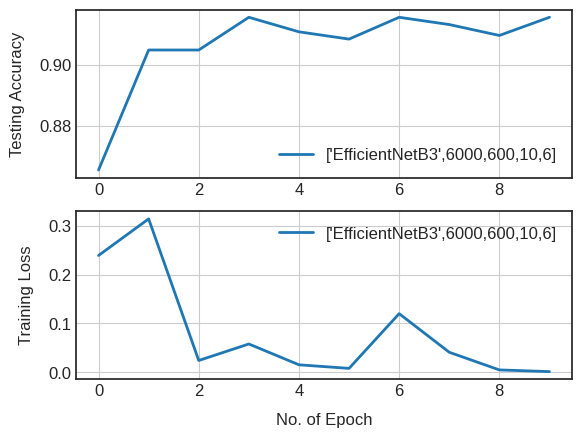

In [ ]:
res_eval(args['sys_res_root'])

In [ ]:
generateClassificationReport(model, test_loader, device, class_labels)

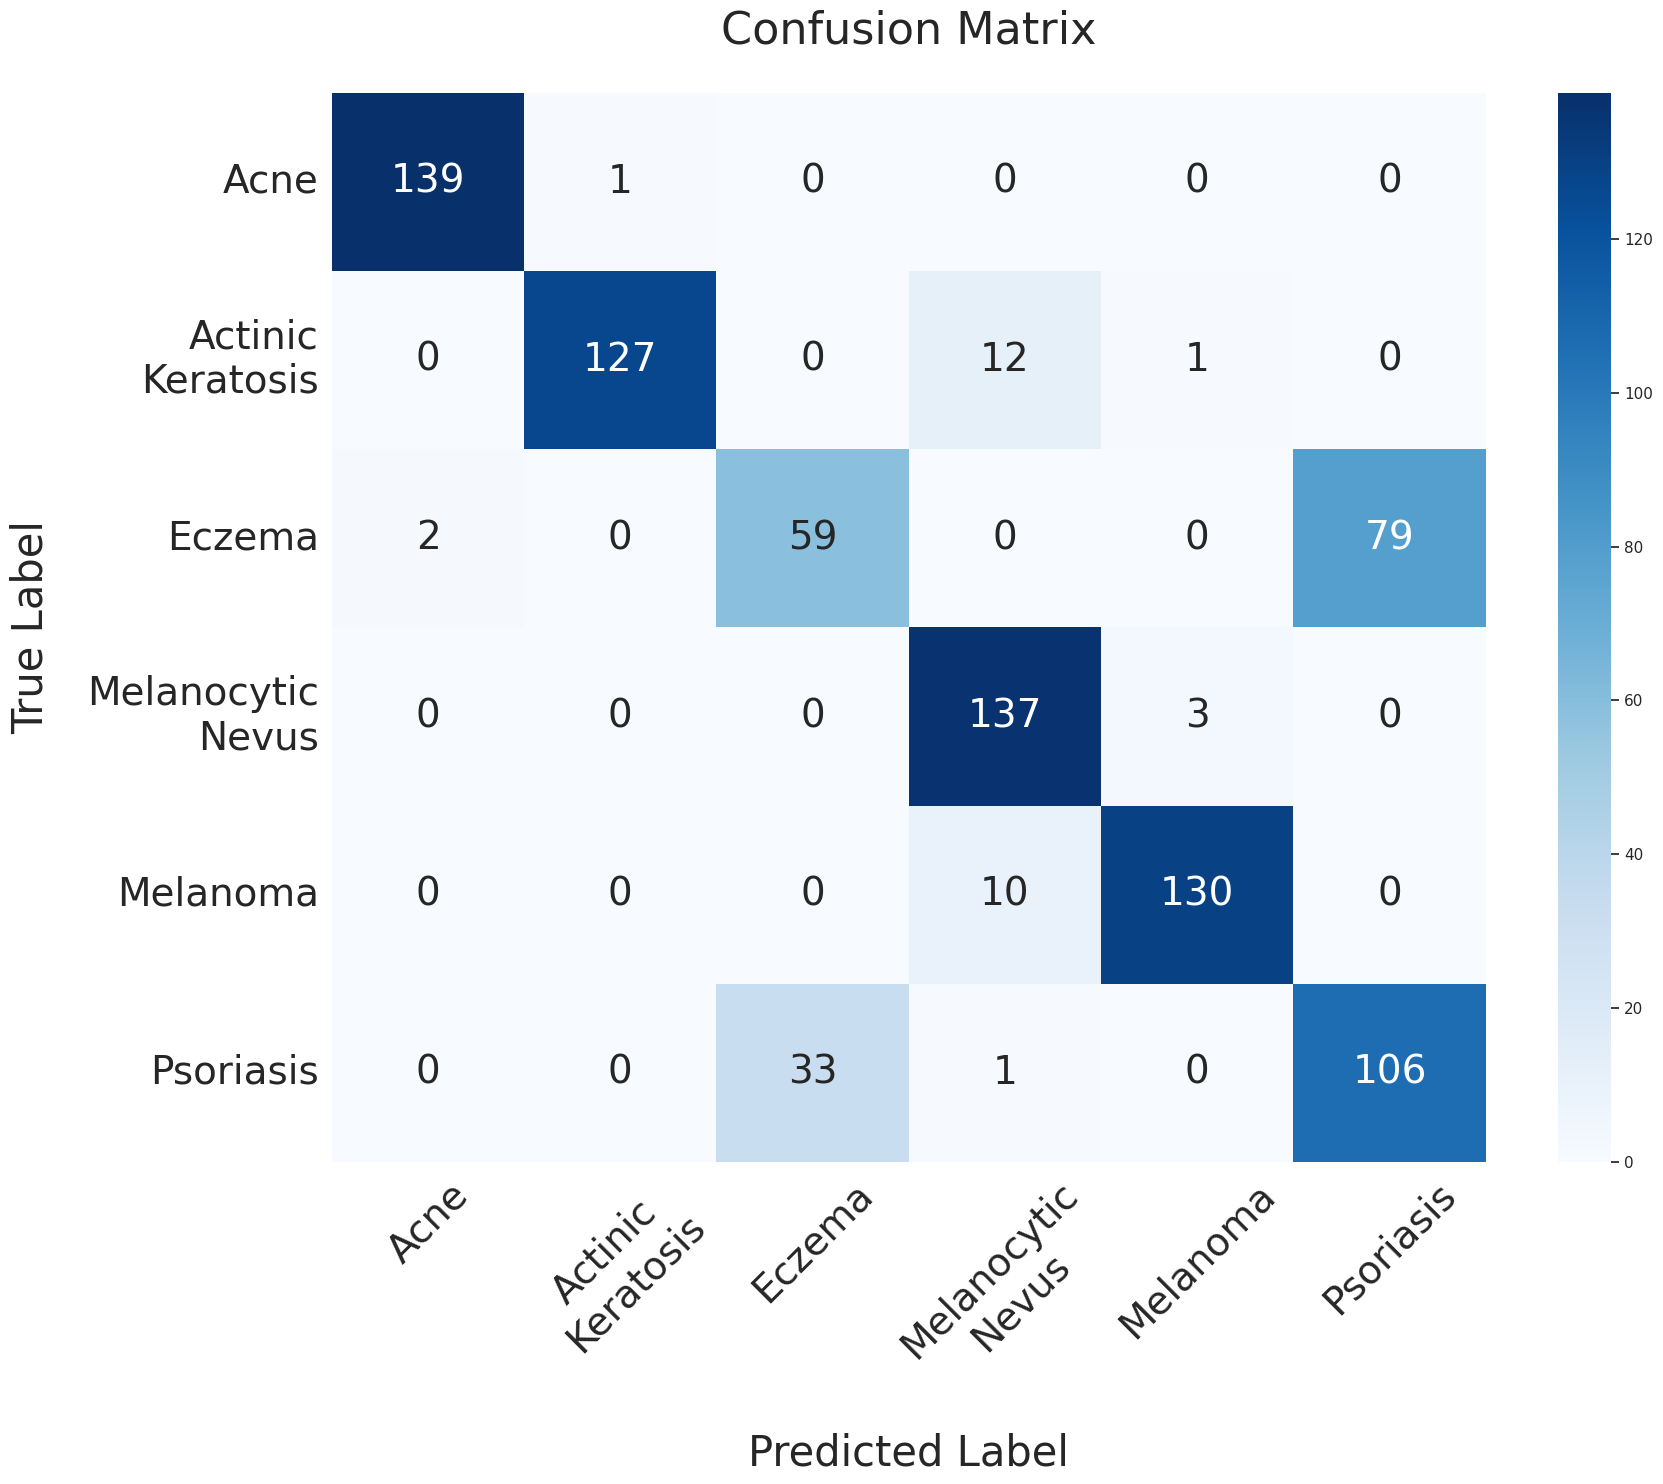

In [ ]:
generateConfusionMatrix(model, test_loader, device, class_labels)

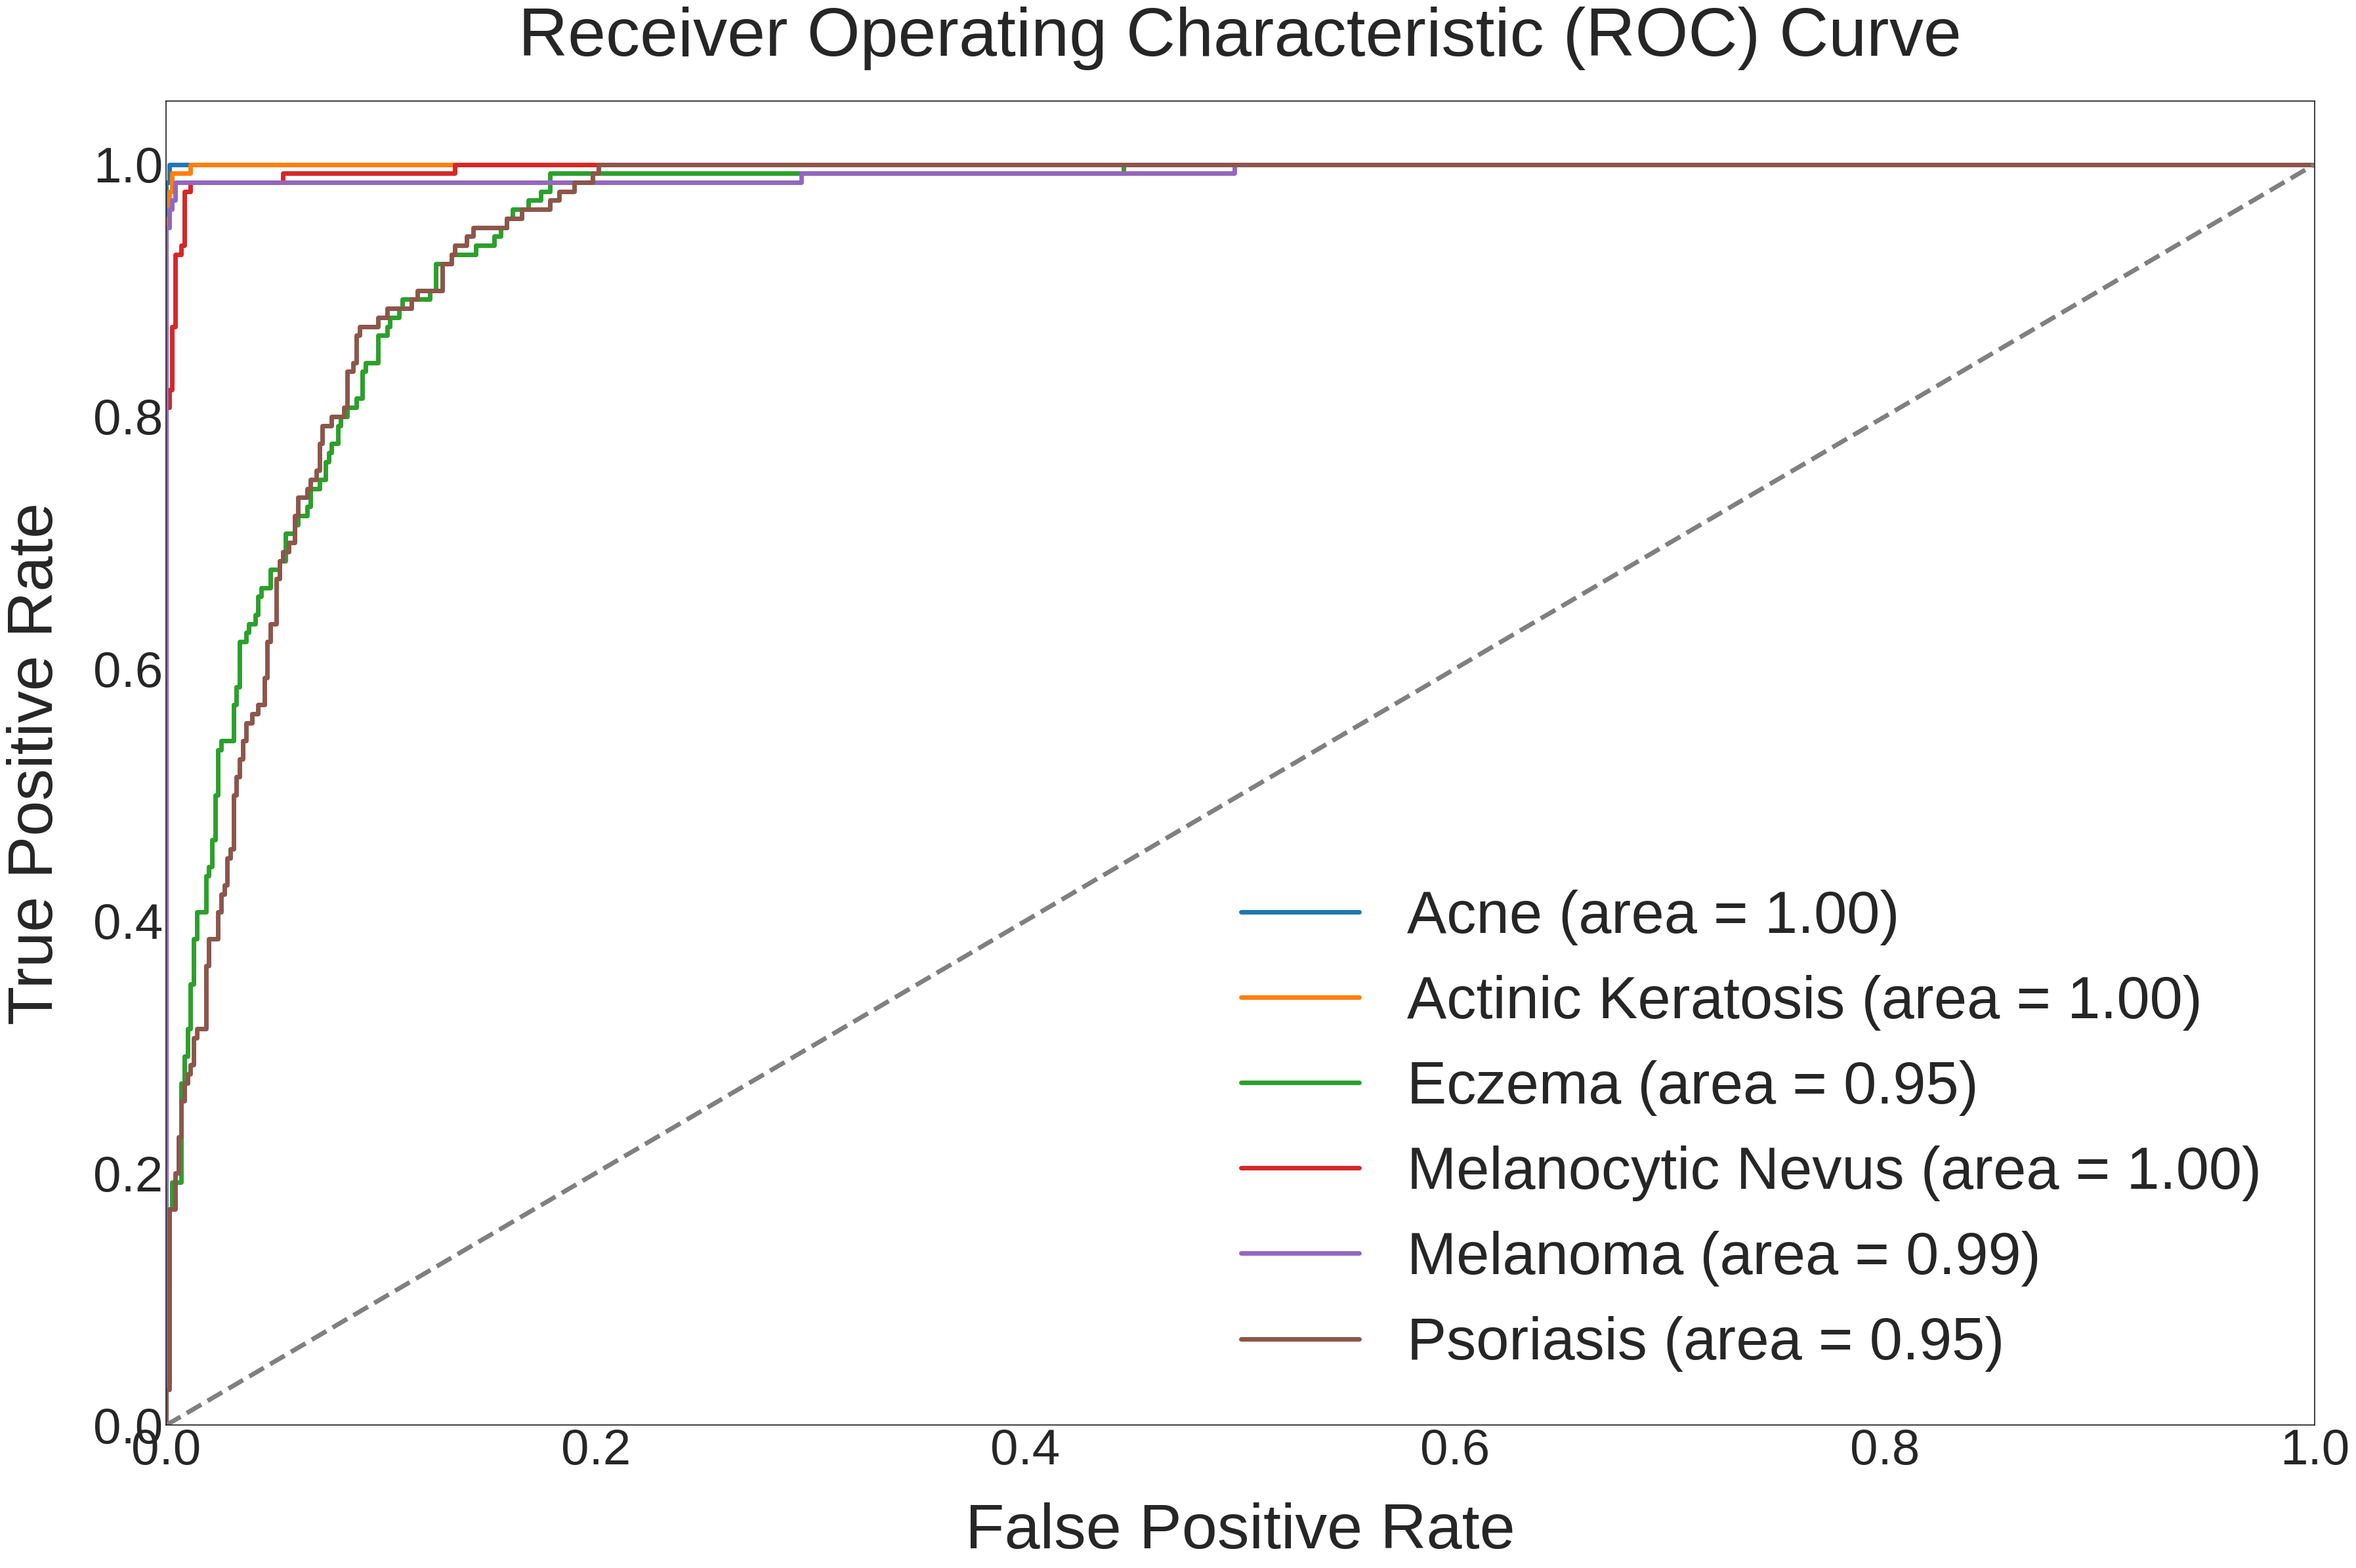

In [ ]:
generateROCCurve(model, test_loader, device, class_labels)

/tmp/ipython-input-2723741271.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes).colors  # Use 'tab20' colormap for variety of colors


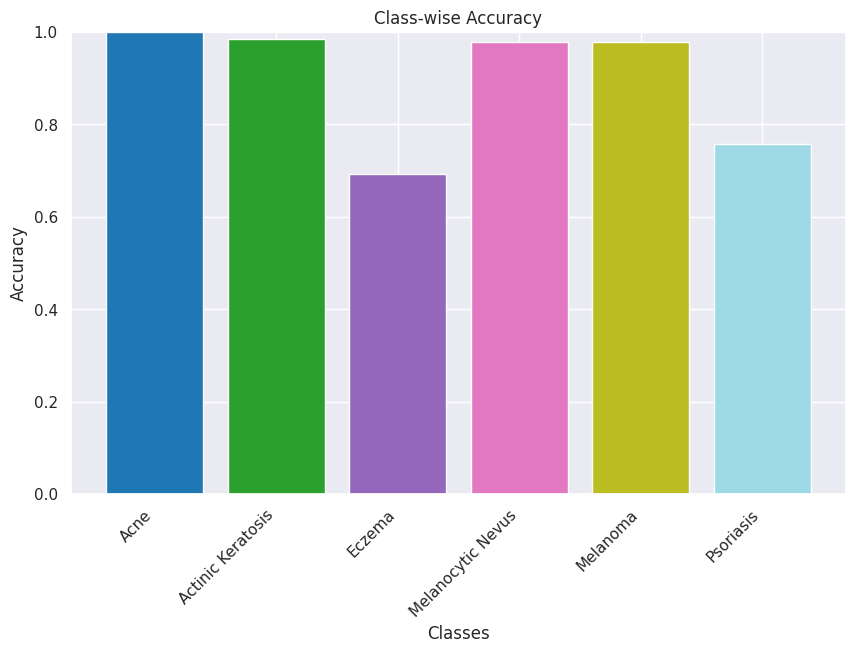

Accuracy for Acne: 1.00
Accuracy for Actinic Keratosis: 0.99
Accuracy for Eczema: 0.69
Accuracy for Melanocytic Nevus: 0.98
Accuracy for Melanoma: 0.98
Accuracy for Psoriasis: 0.76


In [ ]:
generateClassWiseAccuracy(model, test_loader, device, class_labels)

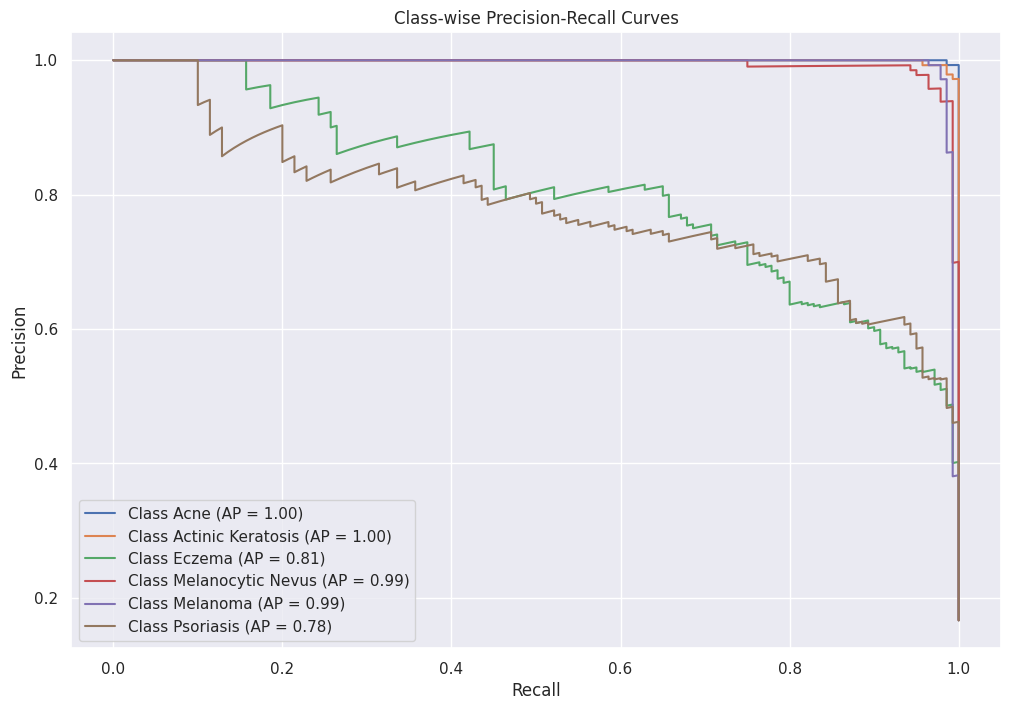

In [ ]:
generateClassWisePRCurves(model, test_loader, device, class_labels)

### Accracy received from simulations having different number of clients

/tmp/ipython-input-766983206.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 8).colors


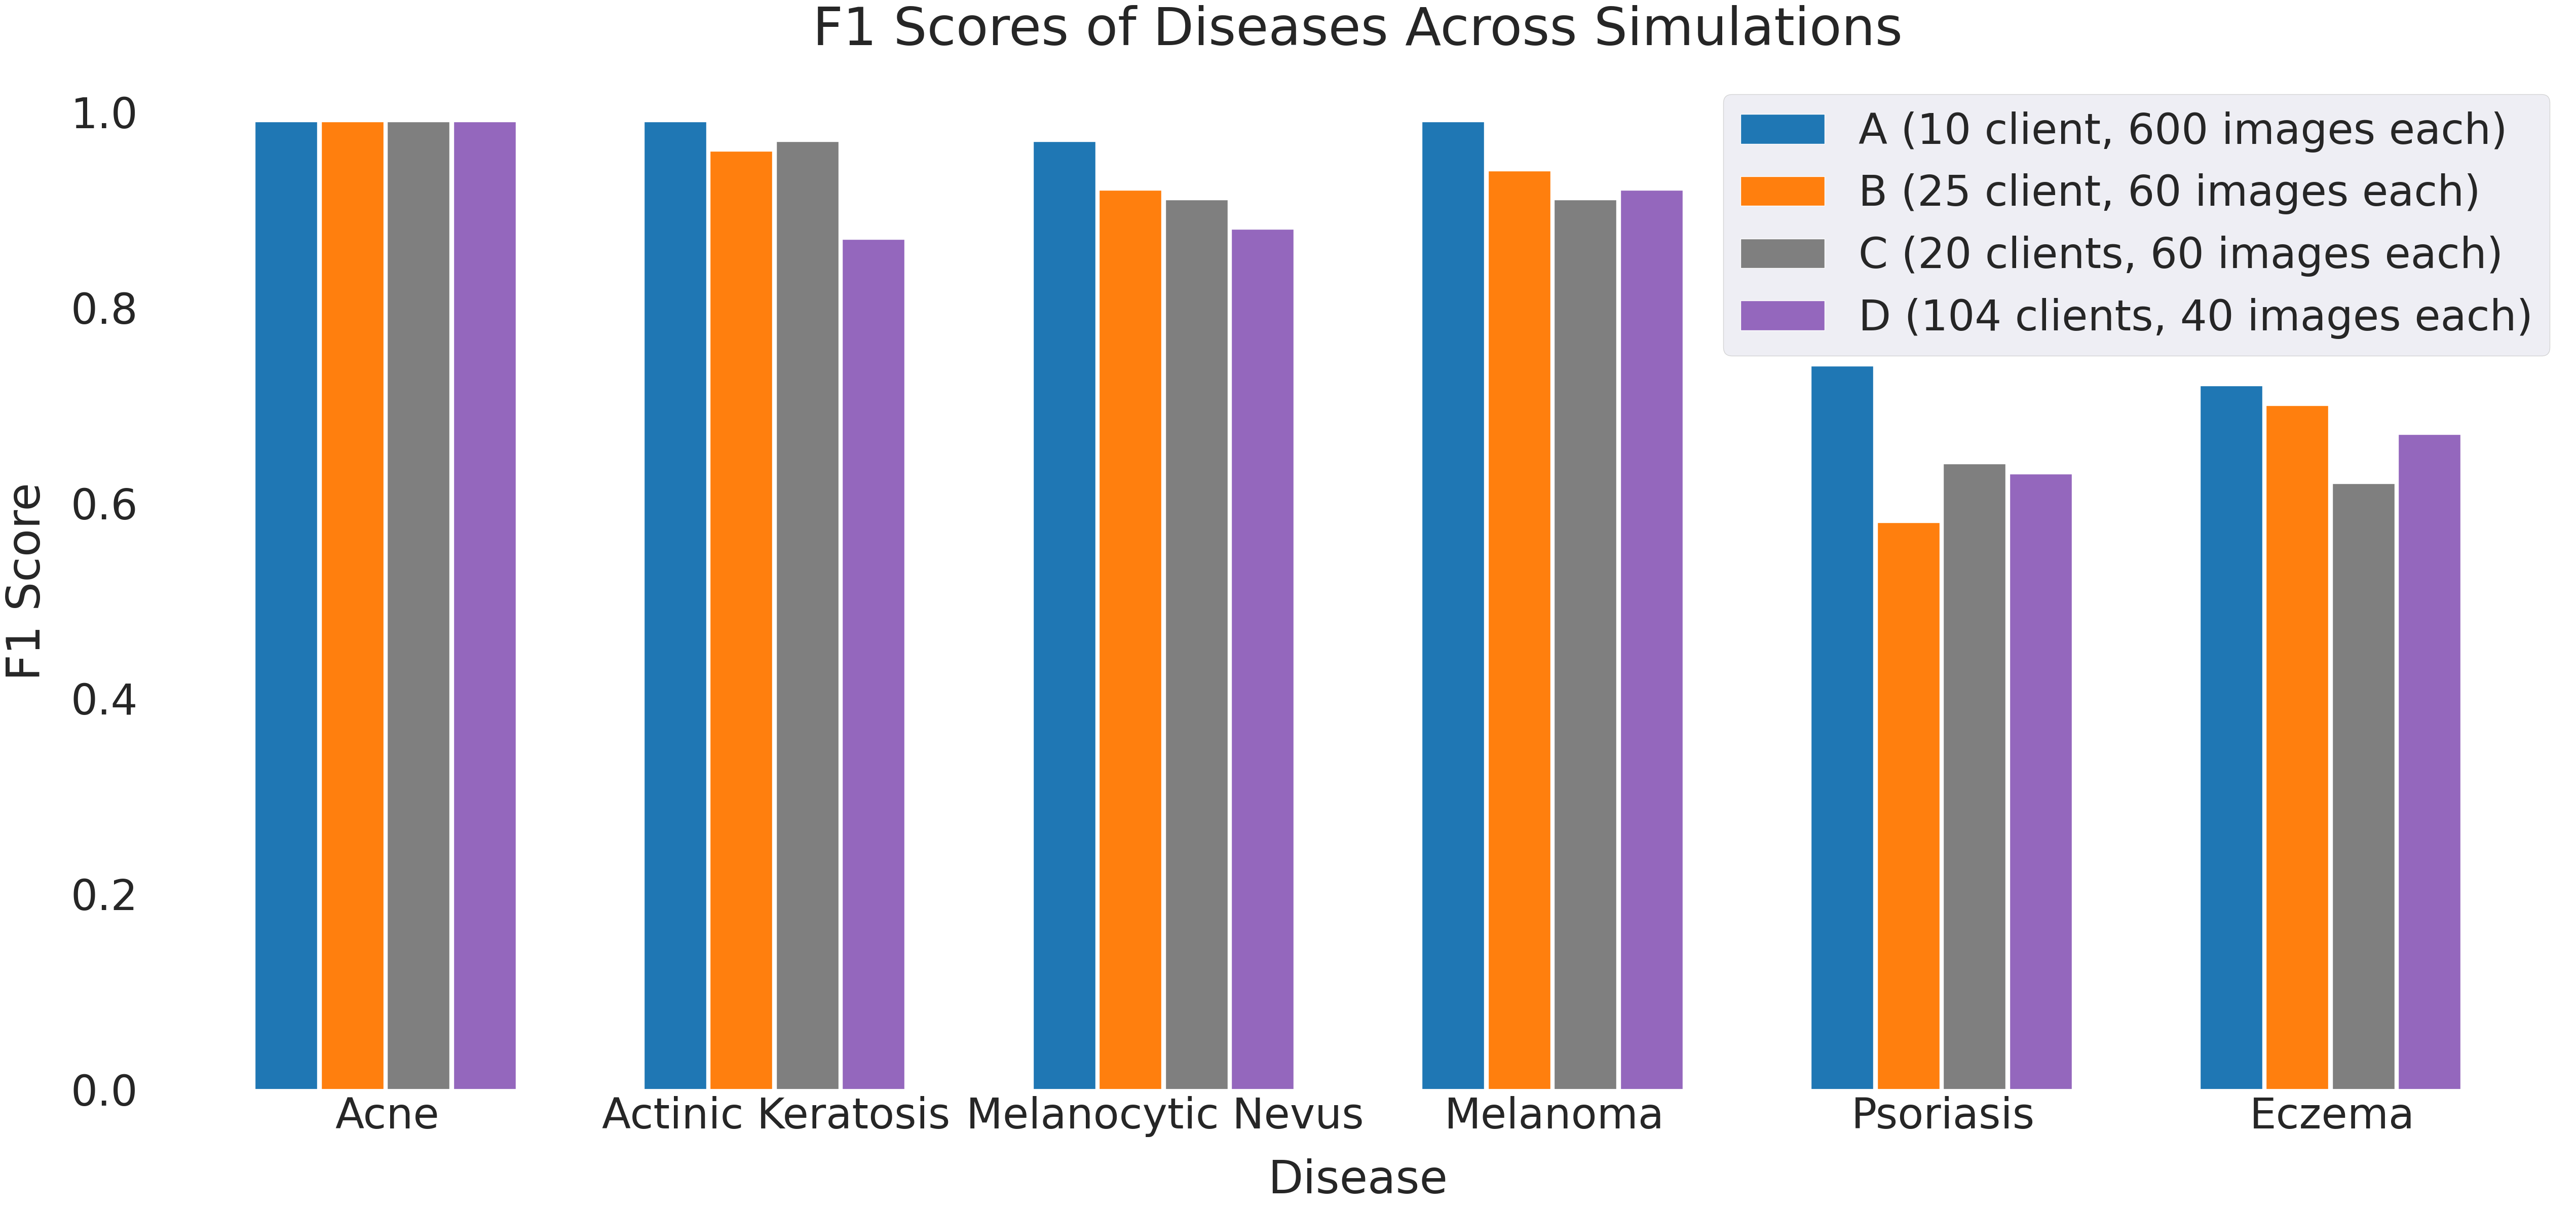

In [ ]:
# F1 scores we got for different number of clients and images


import matplotlib.pyplot as plt
import numpy as np

# Classification reports as dictionaries
report_model1 = {
    'Acne': {'f1-score': 0.99},
    'Actinic Keratosis': {'f1-score': 0.99},
    'Eczema': {'f1-score': 0.72},
    'Melanocytic Nevus': {'f1-score': 0.97},
    'Melanoma': {'f1-score': 0.99},
    'Psoriasis': {'f1-score': 0.74}
}

report_model2 = {
    'Acne': {'f1-score': 0.99},
    'Actinic Keratosis': {'f1-score': 0.96},
    'Eczema': {'f1-score': 0.70},
    'Melanocytic Nevus': {'f1-score': 0.92},
    'Melanoma': {'f1-score': 0.94},
    'Psoriasis': {'f1-score': 0.58}
}

report_model3 = {
    'Acne': {'f1-score': 0.99},
    'Actinic Keratosis': {'f1-score': 0.97},
    'Eczema': {'f1-score': 0.62},
    'Melanocytic Nevus': {'f1-score': 0.91},
    'Melanoma': {'f1-score': 0.91},
    'Psoriasis': {'f1-score': 0.64}
}

report_model4 = {
    'Acne': {'f1-score': 0.99},
    'Actinic Keratosis': {'f1-score': 0.87},
    'Psoriasis': {'f1-score': 0.63},
    'Eczema': {'f1-score': 0.67},
    'Melanocytic Nevus': {'f1-score': 0.88},
    'Melanoma': {'f1-score': 0.92}
}

# Extract the common diseases
common_diseases = ['Acne', 'Actinic Keratosis', 'Melanocytic Nevus', 'Melanoma', 'Psoriasis', 'Eczema']

# Get F1 scores for each model
def get_f1_scores(report, diseases):
    return [report[disease]['f1-score'] if disease in report else np.nan for disease in diseases]

f1_scores_model1 = get_f1_scores(report_model1, common_diseases)
f1_scores_model2 = get_f1_scores(report_model2, common_diseases)
f1_scores_model3 = get_f1_scores(report_model3, common_diseases)
f1_scores_model4 = get_f1_scores(report_model4, common_diseases)

# Create bar graph with increased height
x = np.arange(len(common_diseases))  # the label locations
width = 0.16  # the width of the bars
colors = plt.cm.get_cmap('tab20', 8).colors
fig, ax = plt.subplots(figsize=(51, 24))  # Increase figsize height

fig.patch.set_facecolor('white')  # Set figure background to white
ax.set_facecolor('white')         # Set axes (plotting area) background to white


bars_model1 = ax.bar(x - width*1.5 - 0.02, f1_scores_model1, width, label='A (10 client, 600 images each)', color=colors[0])
bars_model2 = ax.bar(x - width*0.5 - 0.01, f1_scores_model2, width, label='B (25 client, 60 images each)', color=colors[1])
bars_model3 = ax.bar(x + width*0.5, f1_scores_model3, width, label='C (20 clients, 60 images each)', color=colors[5])
bars_model4 = ax.bar(x + width*1.5 + 0.01, f1_scores_model4, width, label='D (104 clients, 40 images each)', color=colors[3])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Disease', fontsize=65, labelpad=30)
ax.set_ylabel('F1 Score', fontsize=65, labelpad=30)
ax.set_title('F1 Scores of Diseases Across Simulations', fontsize=75, pad=40)
ax.set_xticks(x)
ax.set_xticklabels(common_diseases, fontsize=55)
ax.tick_params(axis='x', which='both', labelsize=60)
ax.tick_params(axis='y', which='both', labelsize=60)

# Adjust legend position to top right
ax.legend(loc='upper right', fontsize=60)

fig.tight_layout()

plt.show()

### Accracy received from simulations having different number of images per clients

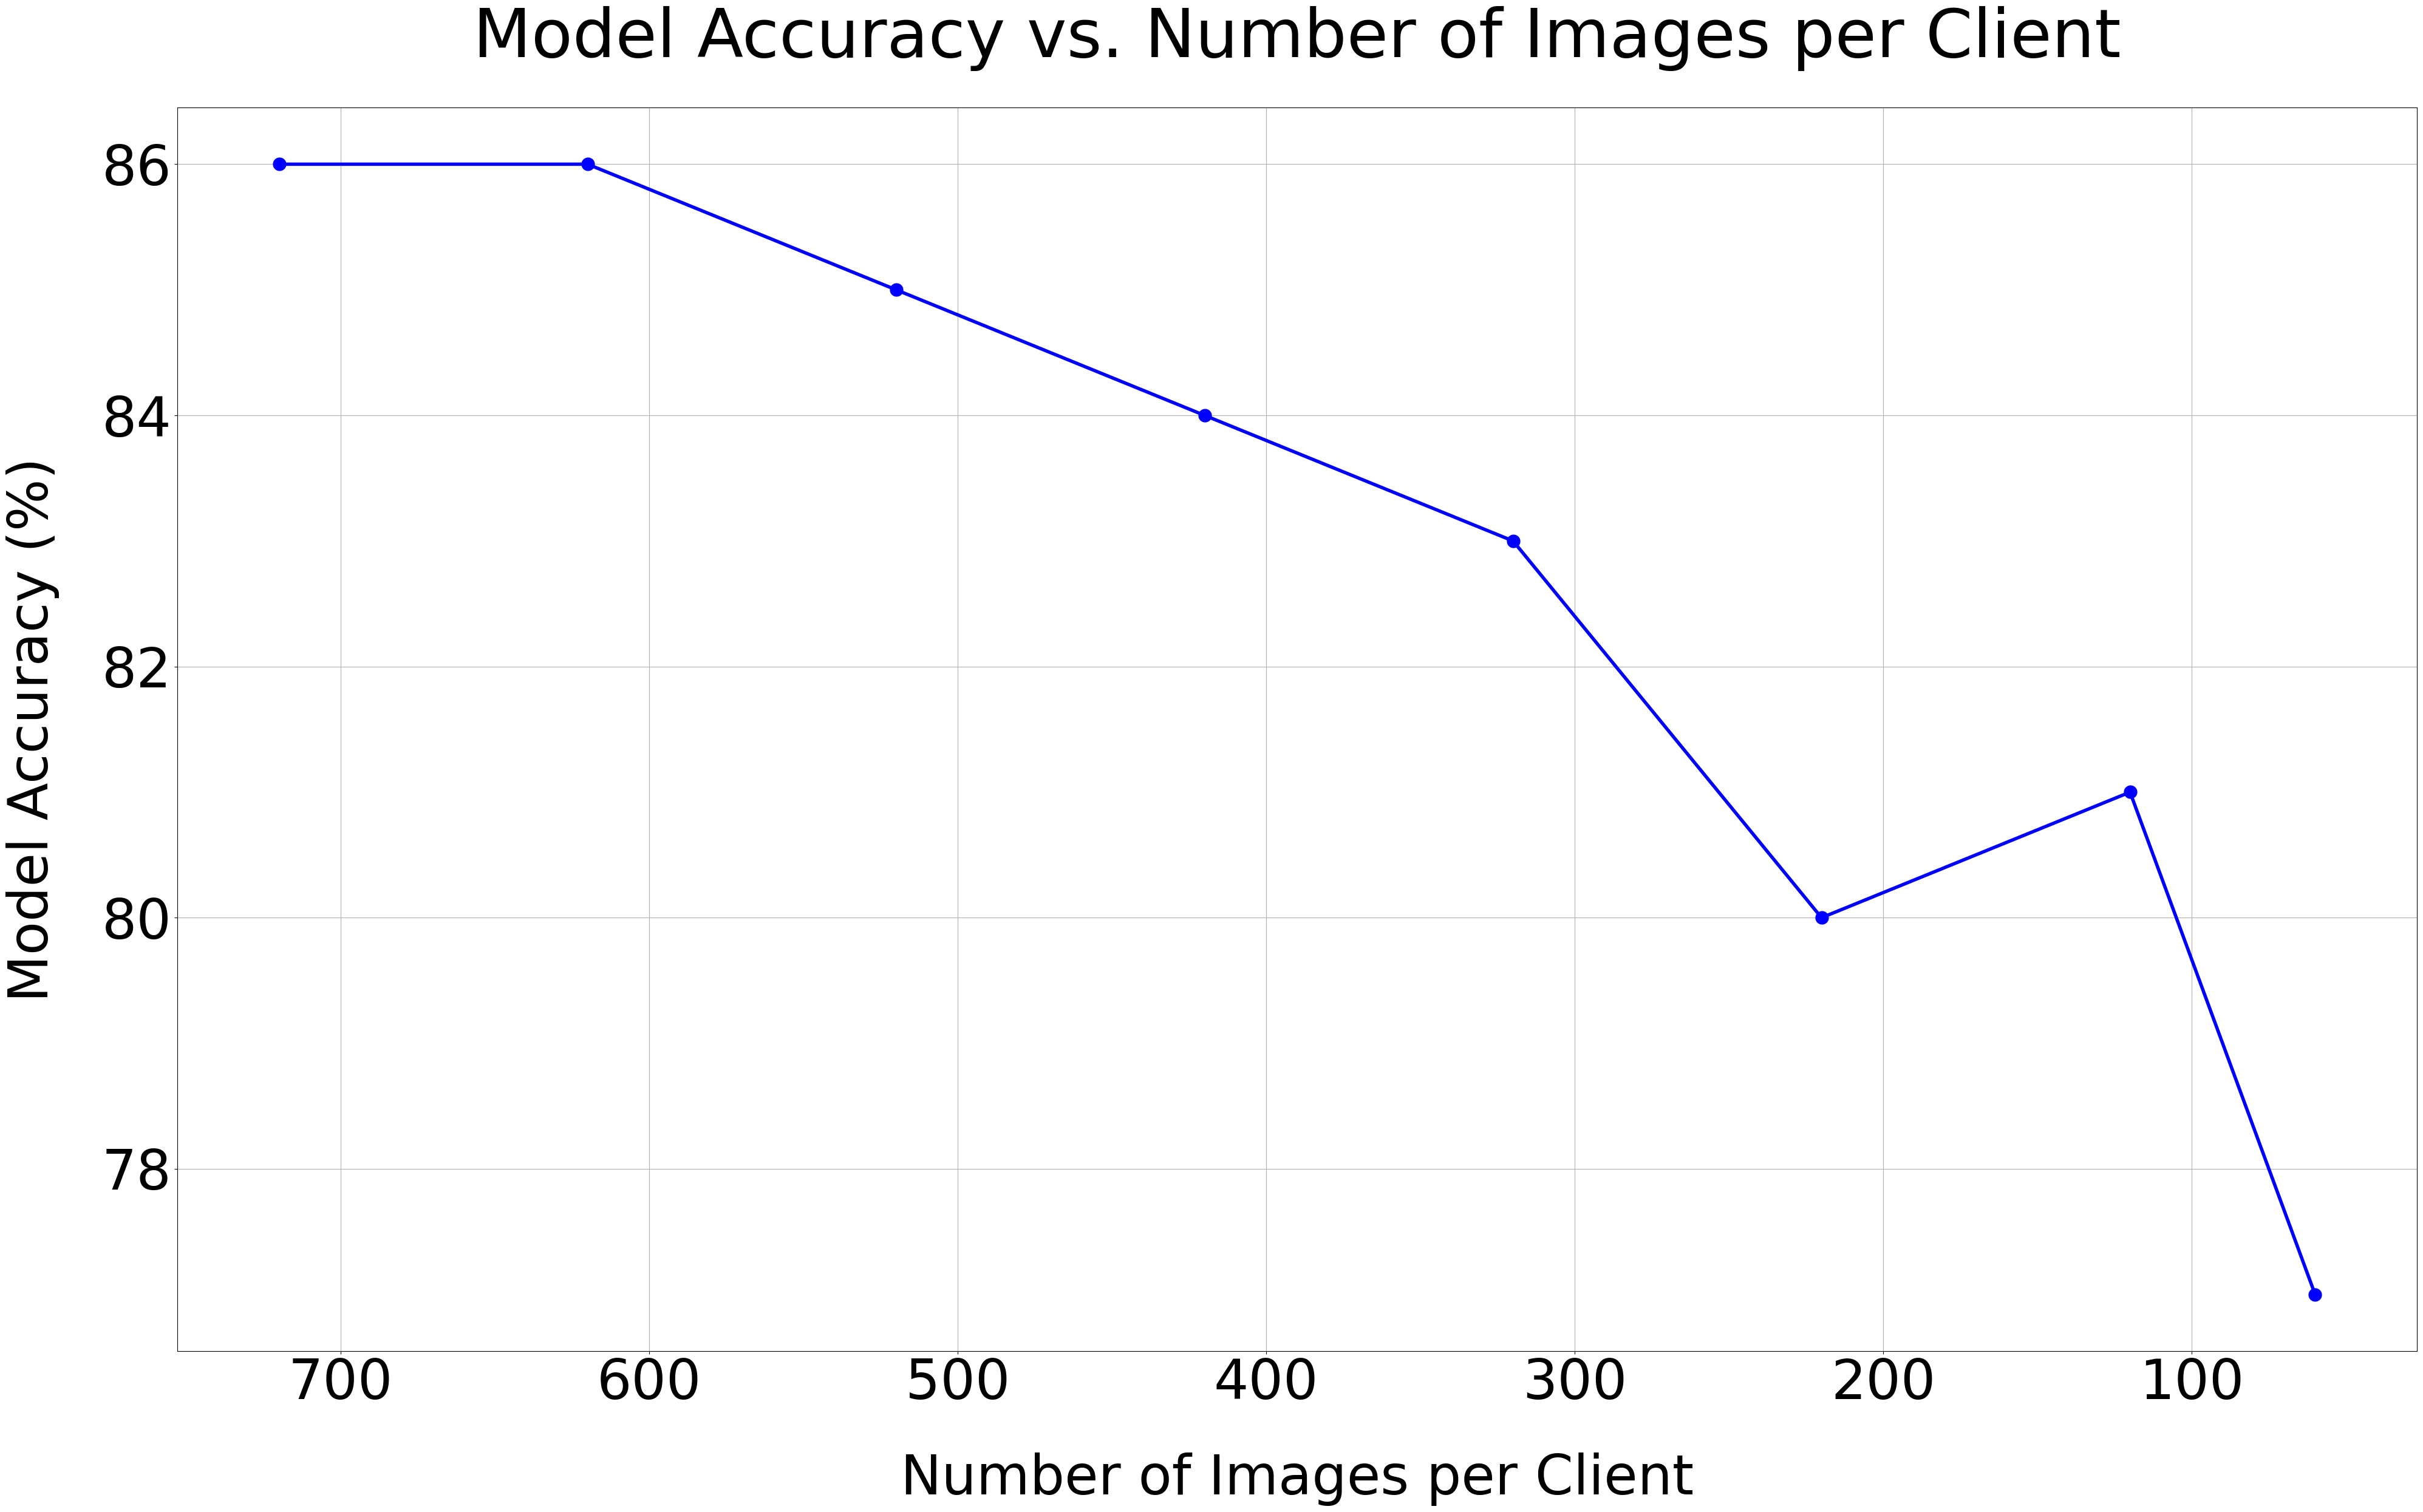

In [ ]:


import matplotlib.pyplot as plt



plt.style.use('default')  # Or use 'default'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

data = [
    [720, 144, 86],
    [620, 120, 86],
    [520, 102, 85],
    [420, 84, 84],
    [320, 60, 83],
    [220, 42, 80],
    [120, 24, 81],
    [60, 12, 77]
]

# Extracting number of images and accuracies
num_images = [entry[0] for entry in data]
accuracies = [entry[2] for entry in data]

# Plotting
plt.figure(figsize=(40, 25))
plt.plot(num_images, accuracies, marker='o', linestyle='-', color='b', linewidth=4, markersize=15)
plt.title('Model Accuracy vs. Number of Images per Client', fontsize=80, pad=60)
plt.xlabel('Number of Images per Client', fontsize=65, labelpad=50)
plt.ylabel('Model Accuracy (%)', fontsize=65, labelpad=50)
plt.xticks(fontsize=65)
plt.yticks(fontsize=65)
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: Show decreasing image count left to right
plt.tight_layout()
plt.show()


In [ ]:
drive_model_path = './drive/MyDrive/Federated_Learning/dump/model.pth'
drive_data_path = './drive/MyDrive/Federated_Learning/dump/data.pkl'

In [ ]:
import torch
import pickle

def save_model_and_data(model, test_loader, device, class_labels, model_path, data_path):
    """Saves the model and test data to local storage.

    Args:
        model: The trained PyTorch model.
        test_loader: The PyTorch DataLoader for the test dataset.
        device: The device (CPU or GPU) where the model is running.
        class_labels: A list or tuple of class labels.
        model_path: The path to save the model.
        data_path: The path to save the test data.
    """

    # Save the model
    torch.save(model.state_dict(), model_path)

    # Save the test data
    with open(data_path, 'wb') as f:
        pickle.dump((test_loader, class_labels), f)

    print("Model and data saved successfully.")

In [ ]:
# save_model_and_data(model, test_loader, device, class_labels, drive_model_path, drive_data_path)

In [ ]:
import torch
import pickle

def load_model_and_data(model, model_path, data_path, device):
    """Loads the model and test data from local storage.

    Args:
        model_path: The path to load the model.
        data_path: The path to load the test data.
        device: The device (CPU or GPU) where the model will be running.

    Returns:
        model: The loaded PyTorch model.
        test_loader: The PyTorch DataLoader for the test dataset.
        class_labels: A list or tuple of class labels.
    """

    # Load the model
    model = model.to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    # Load the test data
    with open(data_path, 'rb') as f:
        test_loader, class_labels = pickle.load(f)

    return model, test_loader, class_labels

In [ ]:

loadedModel = CustomEfficientNetB3(8)
device = 'cuda:0'


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 368MB/s]


Loaded pretrained weights for efficientnet-b3


In [ ]:
model, test_loader, class_labels = load_model_and_data(loadedModel, drive_model_path, drive_data_path, device)

# Centralize ML

In [ ]:
import os
import time
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm

from sklearn.metrics import classification_report


In [ ]:
start = time.perf_counter()

num_classes, train_data, train_targets, test_data, test_targets, class_labels = load_data(
        'final_dataset/', download=True, save_pre_data=False)


# Convert labels to LongTensor
train_targets = train_targets.long()
test_targets = test_targets.long()

# Create TensorDatasets
train_dataset = TensorDataset(train_data, train_targets)
test_dataset = TensorDataset(test_data, test_targets)

# Dataloaders
batch_size = 40
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train and Test Loaders are ready.")



Data loaded from previously saved files
Train and Test Loaders are ready.


In [ ]:
device = 'cuda:0'

In [ ]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

# Load pre-trained EfficientNetB3
weights = EfficientNet_B3_Weights.DEFAULT
model = efficientnet_b3(weights=weights)

# Replace the classifier to match the number of classes
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

model = model.to(device)
print(model)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

end = time.perf_counter()
timing_log['central_data_preprocessing'] = end - start

In [ ]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_correct = 0
        total = 0

        start_time = time.time()

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            epoch_correct += (preds == labels).sum().item()
            total += labels.size(0)

        accuracy = epoch_correct / total
        avg_loss = epoch_loss / total
        duration = time.time() - start_time

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f} - Time: {duration:.2f}s")


In [ ]:
# You can add validation_loader=None if you don't split validation
start = time.perf_counter()
train_model(model, train_loader, None, criterion, optimizer, device, num_epochs=10)

end = time.perf_counter()
timing_log['central_training_complete'] = end - start


Epoch 1/10: 100%|██████████| 189/189 [00:18<00:00, 10.49it/s]


Epoch 1/10 - Loss: 0.3563 - Accuracy: 0.8415 - Time: 18.03s


Epoch 2/10: 100%|██████████| 189/189 [00:17<00:00, 10.69it/s]


Epoch 2/10 - Loss: 0.2161 - Accuracy: 0.9040 - Time: 17.69s


Epoch 3/10: 100%|██████████| 189/189 [00:17<00:00, 10.69it/s]


Epoch 3/10 - Loss: 0.1756 - Accuracy: 0.9250 - Time: 17.68s


Epoch 4/10: 100%|██████████| 189/189 [00:17<00:00, 10.65it/s]


Epoch 4/10 - Loss: 0.1697 - Accuracy: 0.9340 - Time: 17.75s


Epoch 5/10: 100%|██████████| 189/189 [00:17<00:00, 10.65it/s]


Epoch 5/10 - Loss: 0.1072 - Accuracy: 0.9599 - Time: 17.74s


Epoch 6/10: 100%|██████████| 189/189 [00:17<00:00, 10.63it/s]


Epoch 6/10 - Loss: 0.0940 - Accuracy: 0.9644 - Time: 17.78s


Epoch 7/10: 100%|██████████| 189/189 [00:17<00:00, 10.70it/s]


Epoch 7/10 - Loss: 0.0651 - Accuracy: 0.9765 - Time: 17.67s


Epoch 8/10: 100%|██████████| 189/189 [00:17<00:00, 10.69it/s]


Epoch 8/10 - Loss: 0.0636 - Accuracy: 0.9767 - Time: 17.69s


Epoch 9/10: 100%|██████████| 189/189 [00:17<00:00, 10.68it/s]


Epoch 9/10 - Loss: 0.0542 - Accuracy: 0.9809 - Time: 17.69s


Epoch 10/10: 100%|██████████| 189/189 [00:17<00:00, 10.72it/s]

Epoch 10/10 - Loss: 0.0510 - Accuracy: 0.9829 - Time: 17.63s


In [ ]:
print("\n--- Time Report ---")
for step, duration in timing_log.items():
    print(f"{step}: {duration:.4f} seconds")


--- Time Report ---
fedd3_data_preprocessing: 122.4300 seconds
fedd3_data_distilled: 489.3364 seconds
fedd3_training_complete: 126.4849 seconds
central_data_preprocessing: 4.7789 seconds
central_training_complete: 177.3504 seconds
fl_data_preprocessing: 4.2608 seconds
fl_training_complete: 696.5453 seconds


In [ ]:
# Use your existing function to print classification report
generateClassificationReport(model, test_loader, device, class_labels)


                   precision    recall  f1-score   support

             Acne       0.99      0.99      0.99       140
Actinic Keratosis       0.97      0.99      0.98       140
           Eczema       0.73      0.86      0.79       140
Melanocytic Nevus       0.99      0.94      0.97       140
         Melanoma       1.00      0.99      1.00       140
        Psoriasis       0.83      0.71      0.77       140

         accuracy                           0.92       840
        macro avg       0.92      0.92      0.92       840
     weighted avg       0.92      0.92      0.92       840



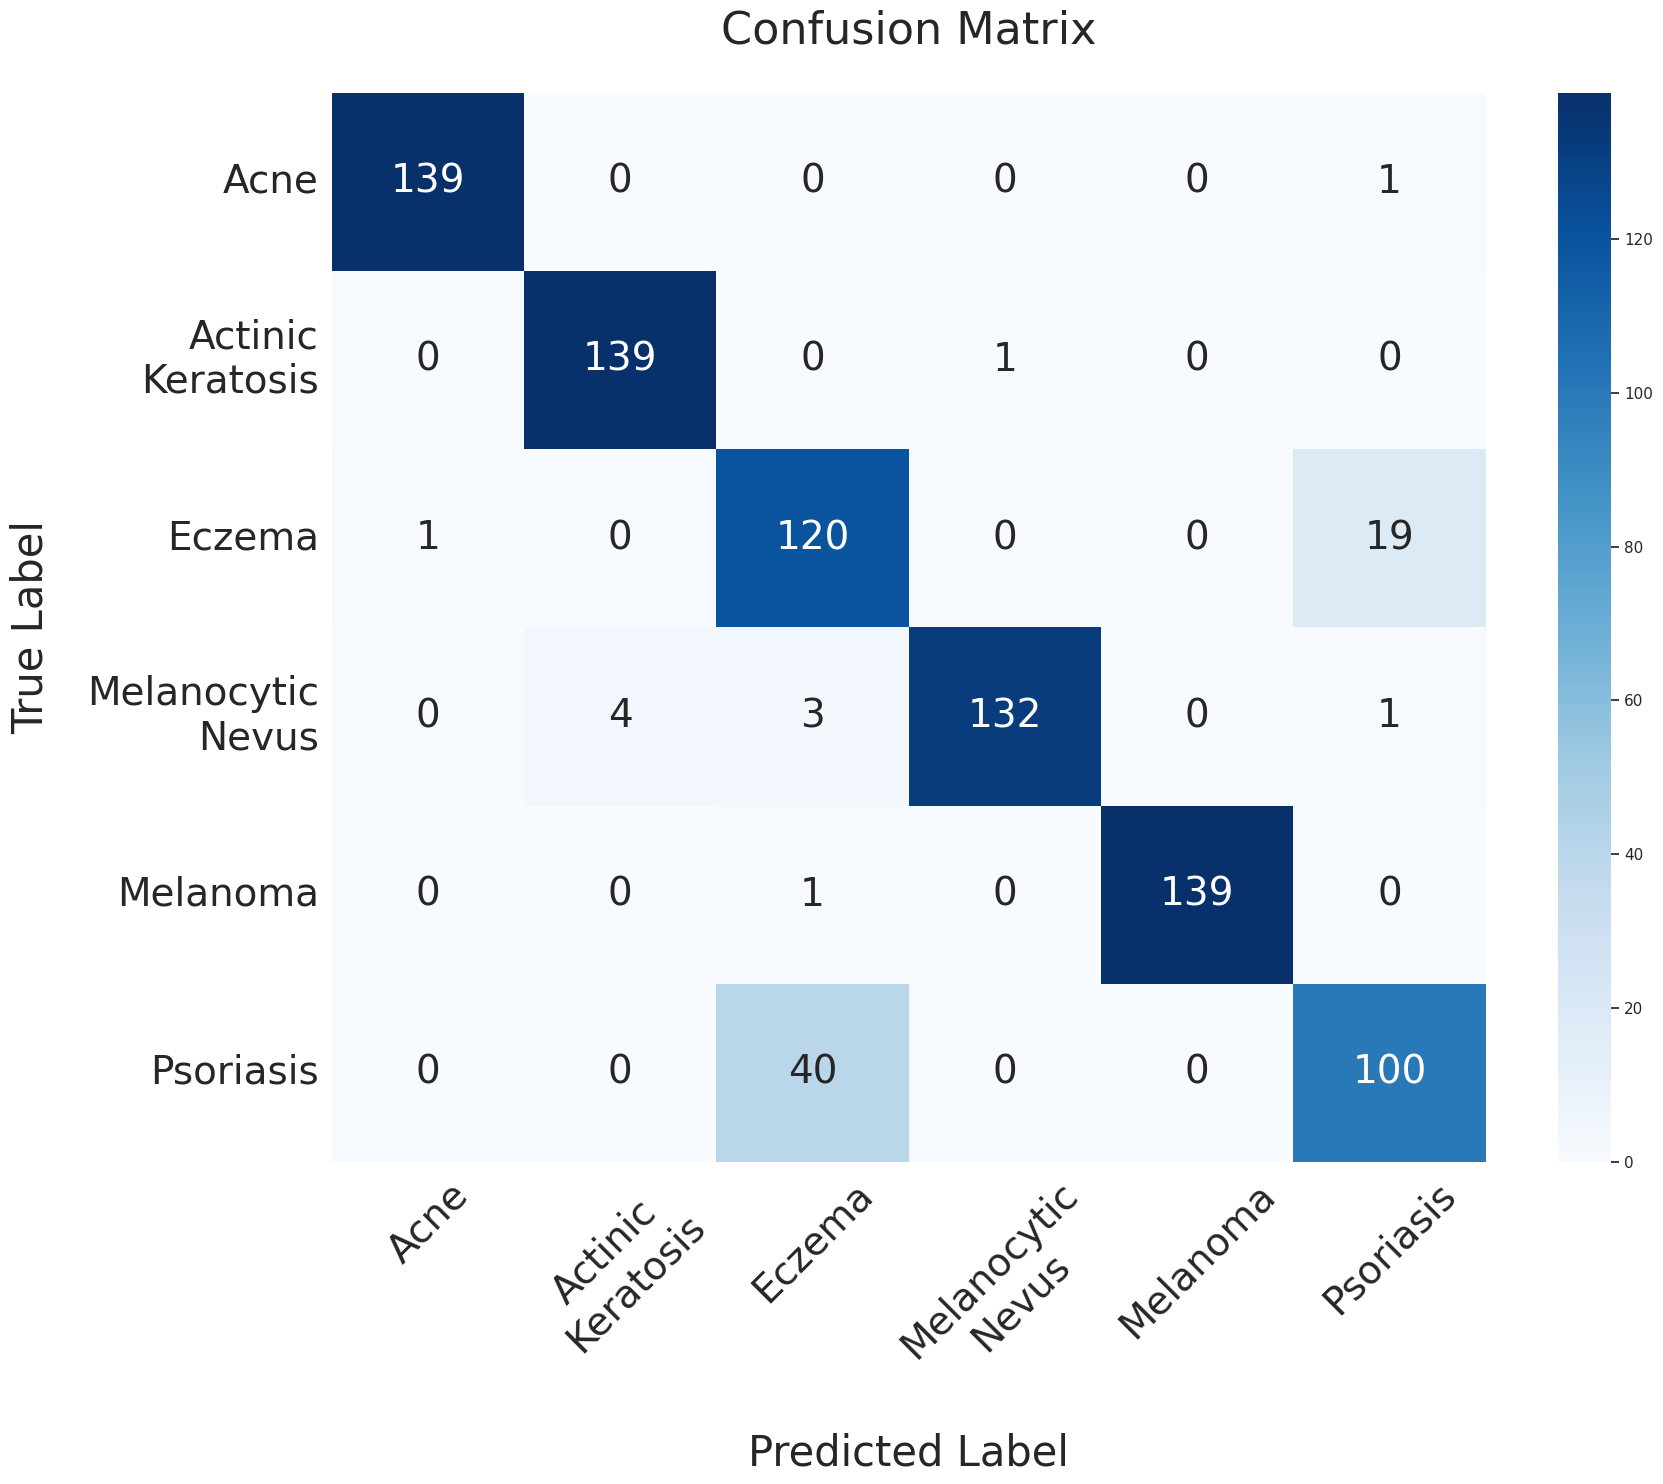

In [ ]:
generateConfusionMatrix(model, test_loader, device, class_labels)

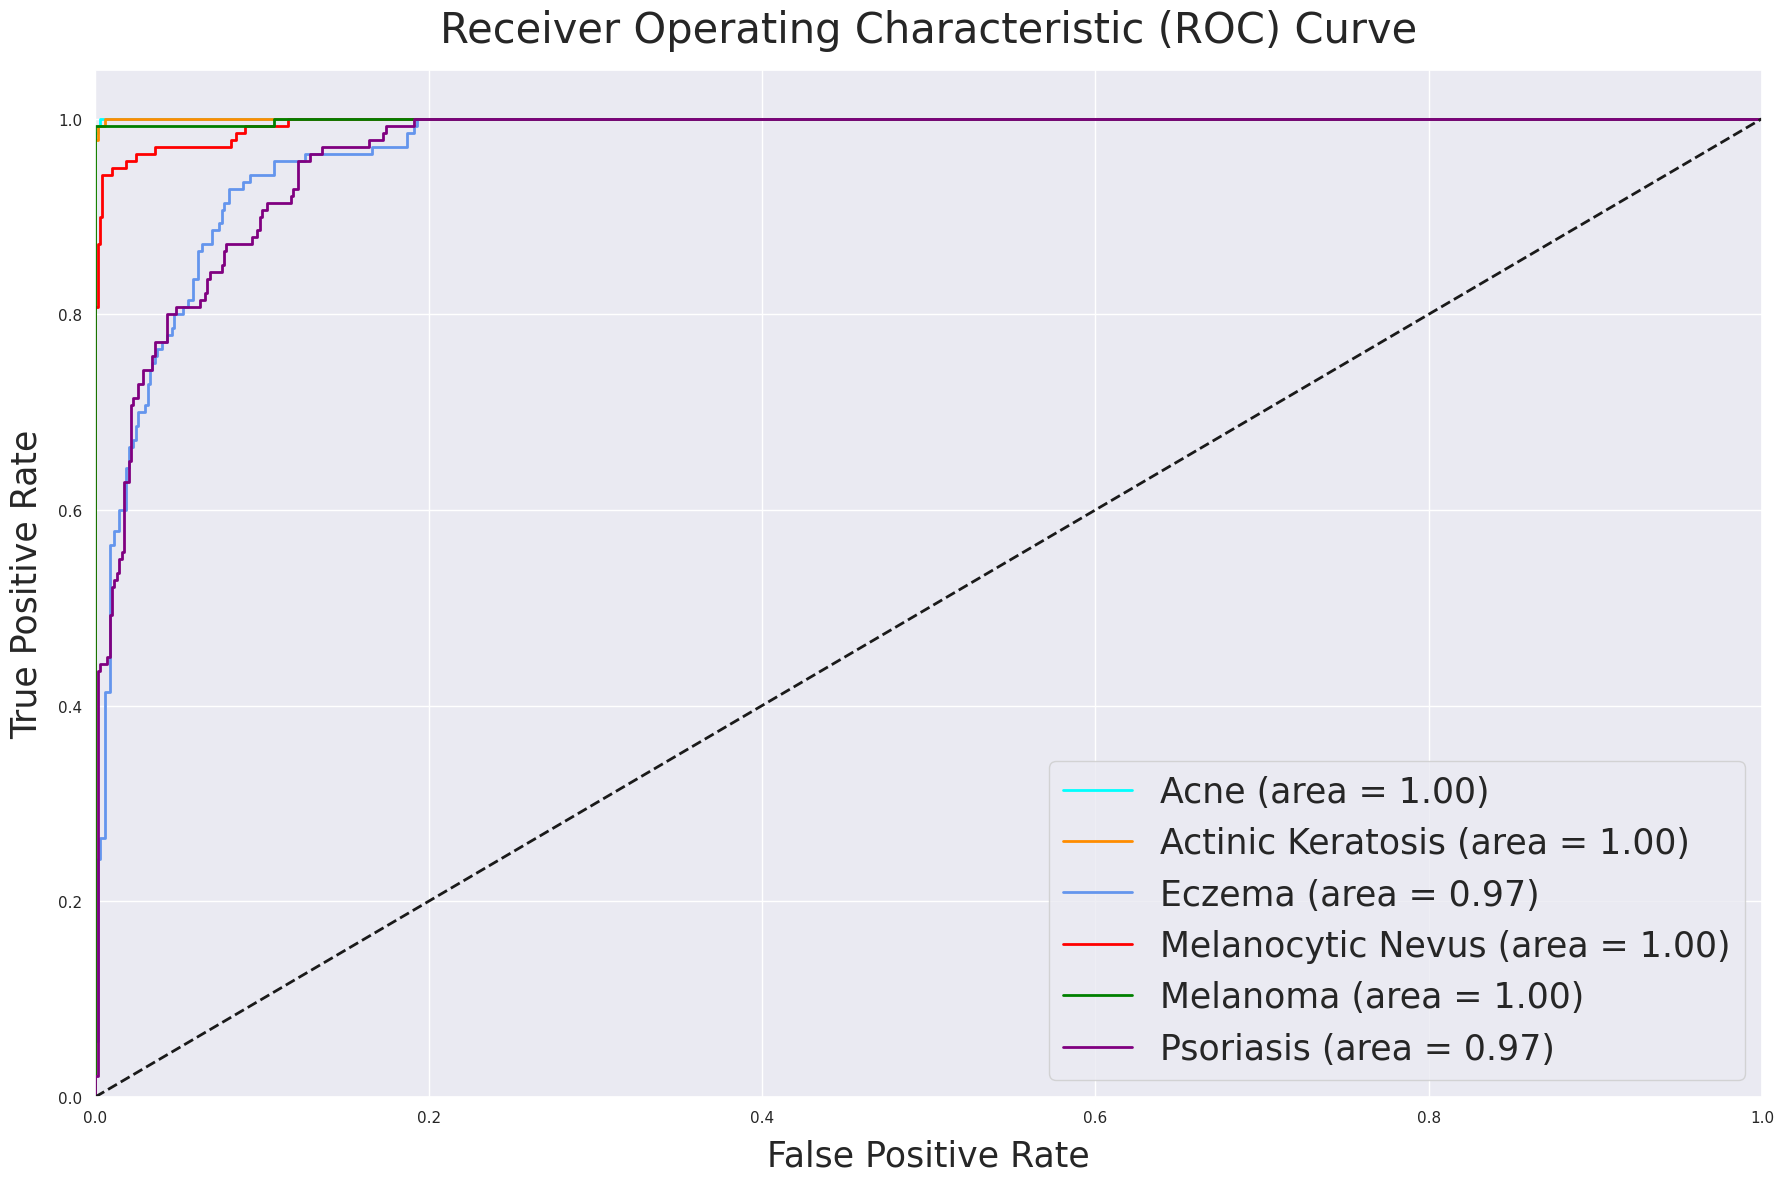

In [ ]:
generateROCCurve(model, test_loader, device, class_labels)

/tmp/ipython-input-48-2723741271.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes).colors  # Use 'tab20' colormap for variety of colors


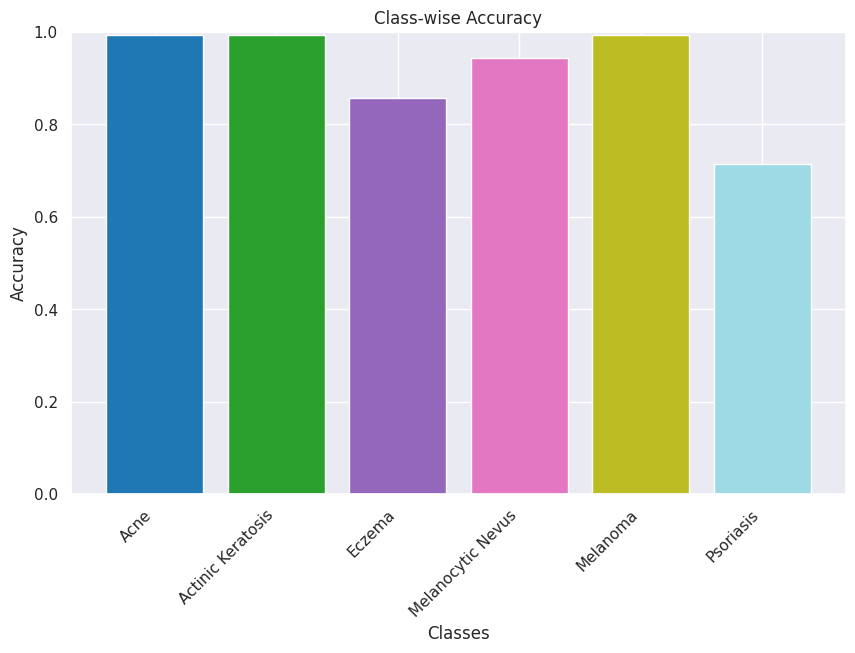

Accuracy for Acne: 0.99
Accuracy for Actinic Keratosis: 0.99
Accuracy for Eczema: 0.86
Accuracy for Melanocytic Nevus: 0.94
Accuracy for Melanoma: 0.99
Accuracy for Psoriasis: 0.71


In [ ]:
generateClassWiseAccuracy(model, test_loader, device, class_labels)

# Normal Federated Learning (FedAvg)

In [ ]:
import os
import time
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from sklearn.metrics import classification_report
from tqdm import tqdm
from copy import deepcopy


In [ ]:
# Load full dataset

start = time.perf_counter()

len_classes, train_data, train_targets, test_data, test_targets, class_labels = load_data(
        'final_dataset/', download=True, save_pre_data=False)

# Convert targets to long type
train_targets = train_targets.long()
test_targets = test_targets.long()

# Create full training dataset
full_train_dataset = TensorDataset(train_data, train_targets)

# Split into 25 parts
num_clients = 25
client_data_size = len(full_train_dataset) // num_clients
client_indices = [list(range(i * client_data_size, (i + 1) * client_data_size)) for i in range(num_clients)]

client_datasets = [Subset(full_train_dataset, indices) for indices in client_indices]
test_dataset = TensorDataset(test_data, test_targets)


Data loaded from previously saved files


In [ ]:
def get_data_loaders(client_datasets, test_dataset, batch_size=32):
    train_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in client_datasets]
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loaders, test_loader

train_loaders, test_loader = get_data_loaders(client_datasets, test_dataset, batch_size=40)

end = time.perf_counter()
timing_log['fl_data_preprocessing'] = end - start


In [ ]:
def create_model(num_classes):
    weights = EfficientNet_B3_Weights.DEFAULT
    model = efficientnet_b3(weights=weights)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model


In [ ]:
def train_local(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()
    model.to(device)

    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


In [ ]:
def average_weights(models):
    avg_model = deepcopy(models[0])
    with torch.no_grad():
        for key in avg_model.state_dict().keys():
            # Average each parameter across all models
            avg_param = sum([client_model.state_dict()[key] for client_model in models]) / len(models)
            avg_model.state_dict()[key].copy_(avg_param)
    return avg_model


In [ ]:
device = 'cuda:0'


start = time.perf_counter()

global_model = create_model(len_classes).to(device)
global_model.train()

criterion = nn.CrossEntropyLoss()

rounds = 5  # number of federated rounds
local_epochs = 5

for rnd in range(rounds):
    print(f"Federated Round {rnd + 1}/{rounds}")
    client_models = []

    for i, train_loader in enumerate(train_loaders):
        client_model = deepcopy(global_model)
        optimizer = optim.AdamW(client_model.parameters(), lr=0.001)
        train_local(client_model, train_loader, criterion, optimizer, device, epochs=local_epochs)
        client_models.append(client_model)

    global_model = average_weights(client_models)


end = time.perf_counter()
timing_log['fl_training_complete'] = end - start


Federated Round 1/5
Federated Round 2/5
Federated Round 3/5
Federated Round 4/5
Federated Round 5/5


In [ ]:
print("\n--- Time Report ---")
for step, duration in timing_log.items():
    print(f"{step}: {duration:.4f} seconds")


--- Time Report ---
fedd3_data_preprocessing: 122.4300 seconds
fedd3_data_distilled: 489.3364 seconds
fedd3_training_complete: 126.4849 seconds
central_data_preprocessing: 4.7789 seconds
central_training_complete: 177.3504 seconds
fl_data_preprocessing: 4.2549 seconds
fl_training_complete: 700.7894 seconds


In [ ]:
# Use your existing function
generateClassificationReport(global_model, test_loader, device, class_labels)

                   precision    recall  f1-score   support

             Acne       0.99      1.00      0.99       140
Actinic Keratosis       1.00      0.98      0.99       140
           Eczema       0.73      0.81      0.77       140
Melanocytic Nevus       0.97      0.99      0.98       140
         Melanoma       0.99      0.99      0.99       140
        Psoriasis       0.80      0.69      0.74       140

         accuracy                           0.91       840
        macro avg       0.91      0.91      0.91       840
     weighted avg       0.91      0.91      0.91       840



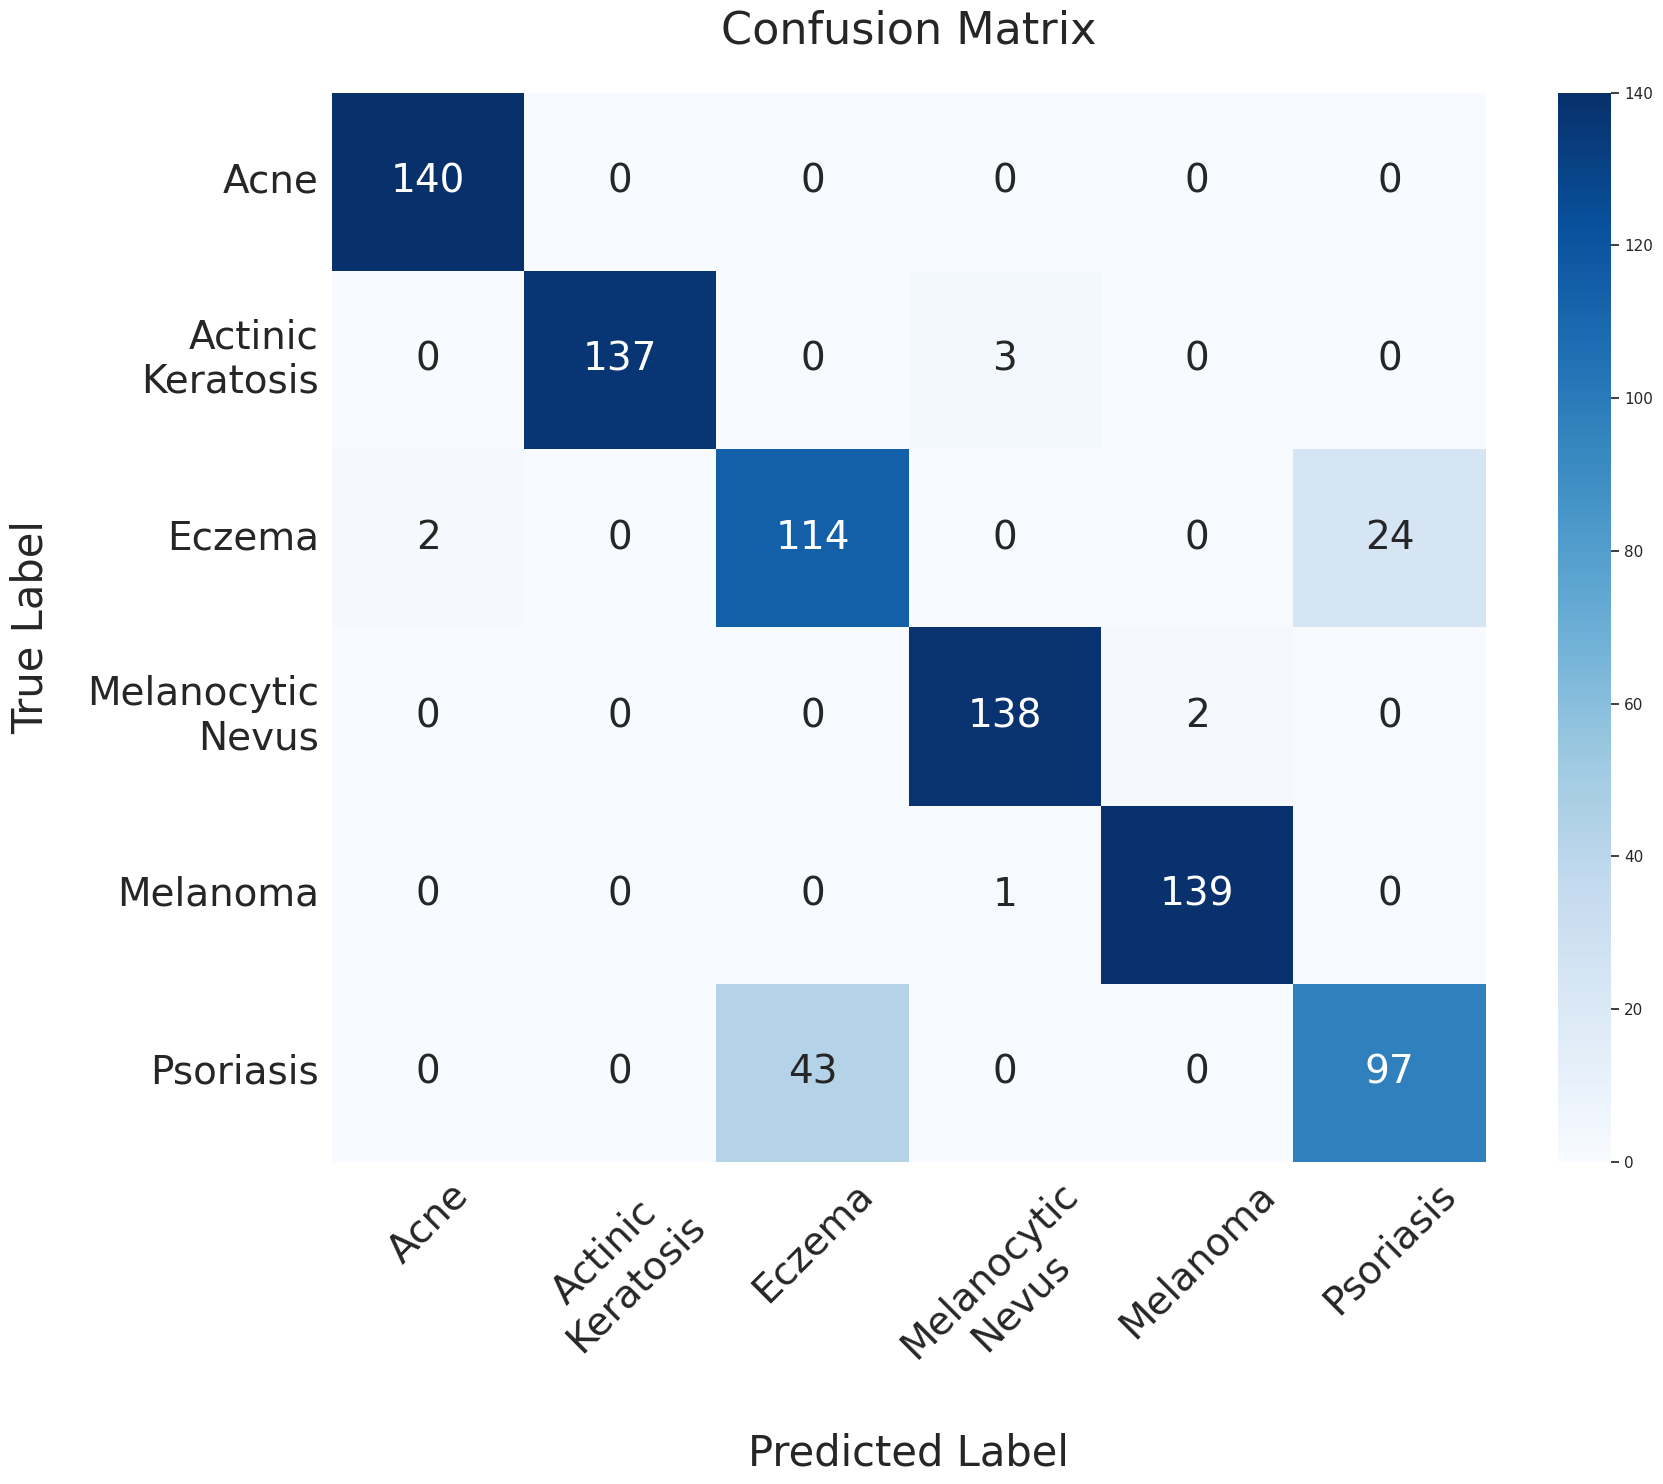

In [ ]:
generateConfusionMatrix(global_model, test_loader, device, class_labels)

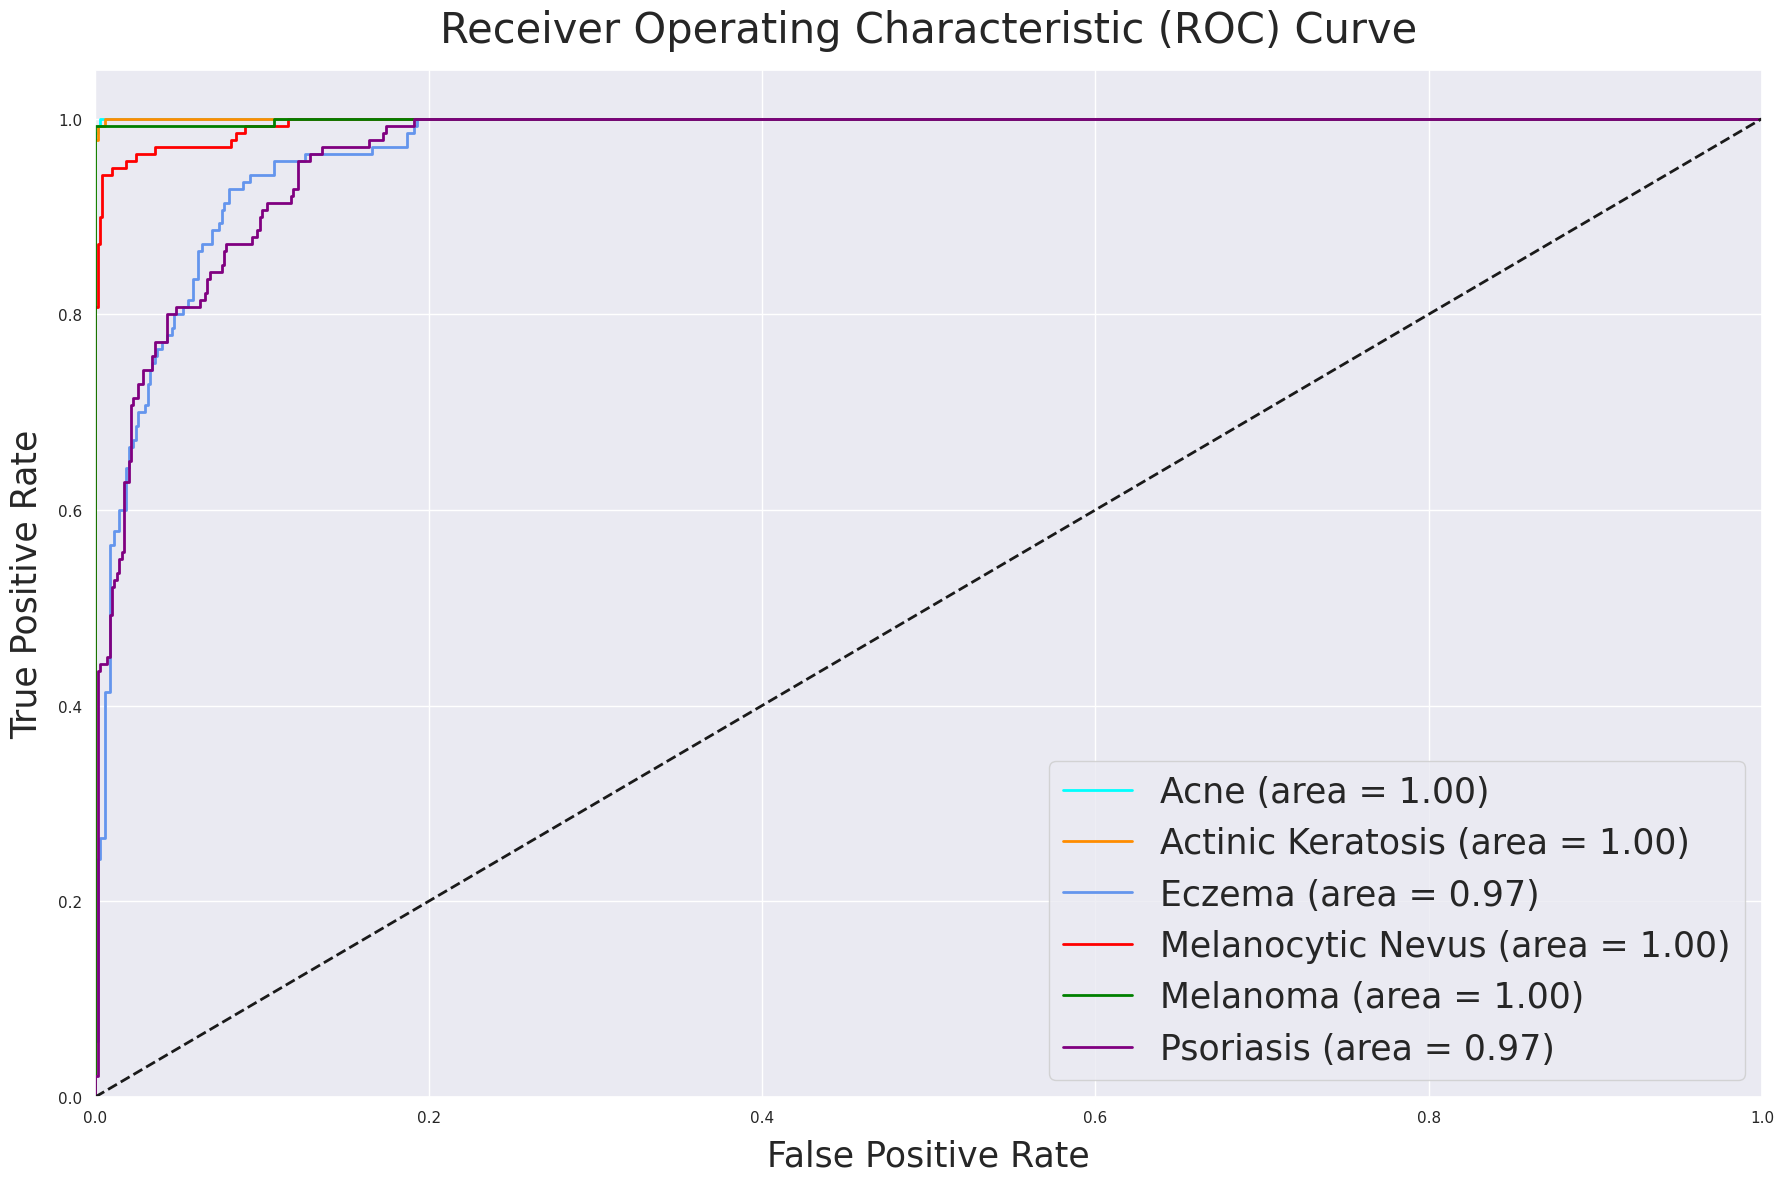

In [ ]:
generateROCCurve(model, test_loader, device, class_labels)

/tmp/ipython-input-48-2723741271.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes).colors  # Use 'tab20' colormap for variety of colors


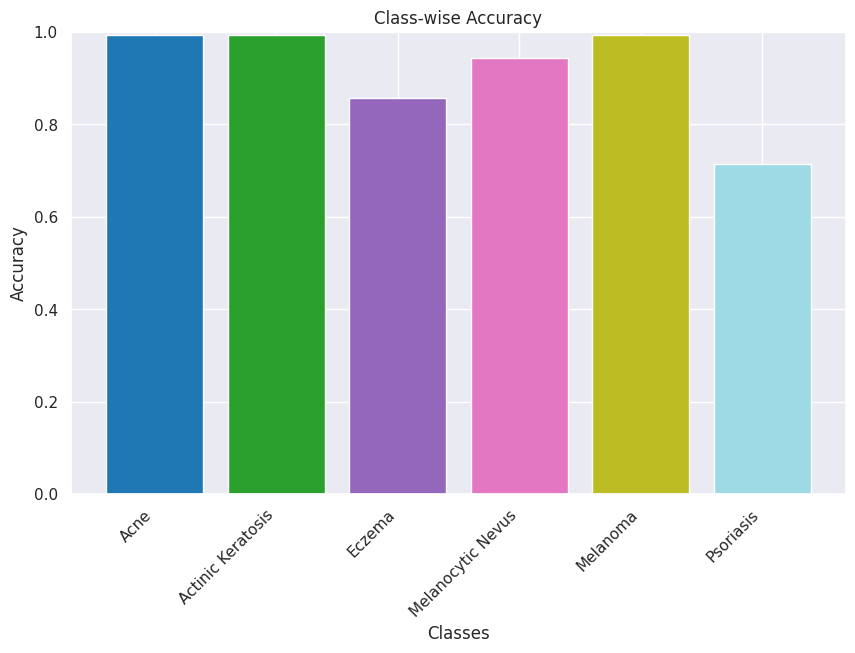

Accuracy for Acne: 0.99
Accuracy for Actinic Keratosis: 0.99
Accuracy for Eczema: 0.86
Accuracy for Melanocytic Nevus: 0.94
Accuracy for Melanoma: 0.99
Accuracy for Psoriasis: 0.71


In [ ]:
generateClassWiseAccuracy(model, test_loader, device, class_labels)

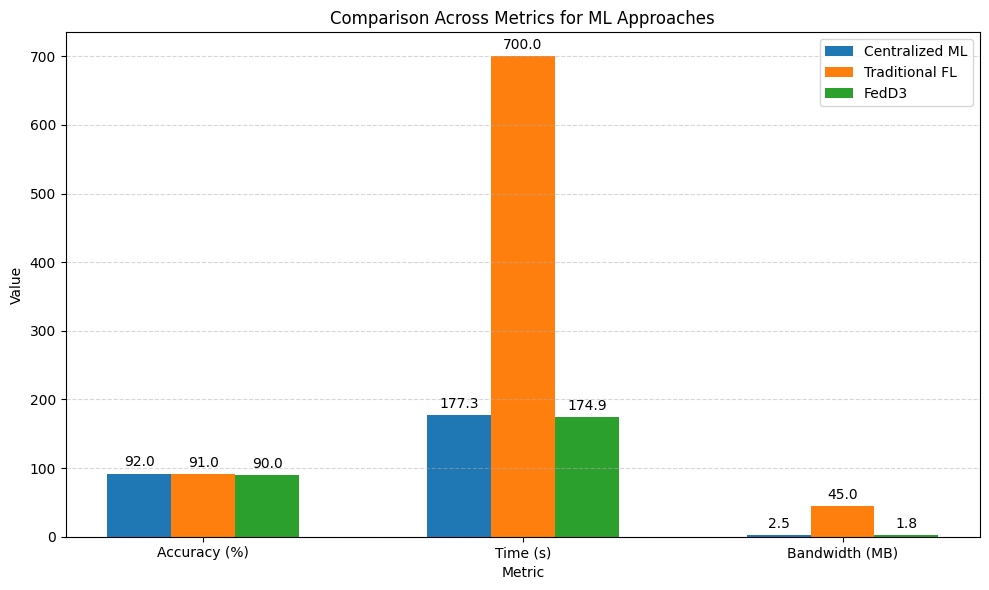

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Labels for methods and metrics
methods = ['Centralized ML', 'Traditional FL', 'FedD3']
metrics = ['Accuracy (%)', 'Time (s)', 'Bandwidth (MB)']

# Metric values by method
centralized = [92, 177.35, 2.52]
traditional = [91, 700, 45]
fedd3 = [90, 174.9, 1.8]

# Combine method values into a single array for grouped plotting
data = np.array([centralized, traditional, fedd3])  # Shape: (3, 4)
data = data.T  # Transpose to shape: (4, 3) → metrics x methods

# X-axis positions for each metric group
x = np.arange(len(metrics))
width = 0.2

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each method
bars1 = ax.bar(x - width, data[:, 0], width, label='Centralized ML')
bars2 = ax.bar(x,         data[:, 1], width, label='Traditional FL')
bars3 = ax.bar(x + width, data[:, 2], width, label='FedD3')

# Axis formatting
ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Comparison Across Metrics for ML Approaches')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
